This script performs the analysis of the proteomics data at 4 h.

In [1]:
import pandas, numpy, seaborn, matplotlib_venn

In [2]:
import sklearn, sklearn.preprocessing, sklearn.decomposition
import scipy, scipy.signal
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':40})

In [4]:
import warnings
warnings.filterwarnings('ignore')

### user-defined variables

In [5]:
four_input_file = '/home/adrian/projects/vigur/data/proteomics/HPMVEC_Proteomics_September_2022/HPMVECs_september2022_4h_all_prts_Relative_Quantification.csv'
twentyfour_input_file = '/home/adrian/projects/vigur/data/proteomics/HPMVEC_Proteomics_September_2022/HPMVECs_september2022_24h_all_prts_Relative_Quantification.csv'

In [6]:
# biomarkers
biomarkers = {
    'endothelin':'P05305',
    'PAI-1':'P05121',
    'uPA':'P00749',
    'VCAM-1':'P19320',
    'L-selectin':'P14151',
    'Ang2':'O15123',
    'VEGFr1':'P17948',
    'ICAM-2':'P13598',
    'tie2':'Q02763',
    'IL-6':'P05231',
    'E-selectin':'P16581',
    'ICAM-1':'P05362',
    'P-selectin':'P16109',
    'Ang1':'Q15389',
    'vWF':'P04275',
    'PDGF':'P01127',
    'endocan':'Q9NQ30',
    'TNFa':'P01375',
    'VEGFa':'P15692'
}

### define metadata

In [7]:
metadata = {}

metadata['4h control'] = ['20220905_ARNAR_010', '20220905_ARNAR_011', '20220905_ARNAR_035', '20220905_ARNAR_036', '20220905_ARNAR_058', '20220905_ARNAR_059']

metadata['4h epi'] = ['20220905_ARNAR_004', '20220905_ARNAR_005', '20220905_ARNAR_008', '20220905_ARNAR_009', '20220905_ARNAR_051', '20220905_ARNAR_052']


metadata['4h nor'] = ['20220905_ARNAR_013', '20220905_ARNAR_014', '20220905_ARNAR_019', '20220905_ARNAR_020', '20220905_ARNAR_044', '20220905_ARNAR_046']

metadata['4h epinor'] = ['20220905_ARNAR_024', '20220905_ARNAR_025', '20220905_ARNAR_026', '20220905_ARNAR_027']

metadata['4h TNFa'] = ['20220905_ARNAR_060', '20220905_ARNAR_065']

all_sample_names = [element for sublist in list(metadata.values()) for element in sublist]
print(len(all_sample_names))

24


### read data

In [8]:
df4 = pandas.read_csv(four_input_file, index_col=0, skiprows=2, sep=',')
df4.shape

(3183, 85)

In [9]:
df4.loc[['P05121', 'P13598', 'P05362'], ]

Peptide count  Unique peptides  Confidence score  Anova (p)  \
Accession                                                                
P05121                41               19          215.7082   0.075943   
P13598                13                4           73.0967   0.143520   
P05362                 7                2           38.8919   0.037111   

            q Value  Max fold change     Power Highest mean condition  \
Accession                                                               
P05121     0.024041         1.455217  0.602788              NorEPI 4h   
P13598     0.032430         1.399022  0.706830                TNFa 4h   
P05362     0.017843         2.982438  0.869784                TNFa 4h   

          Lowest mean condition        Mass  ... 20220905_ARNAR_044.2  \
Accession                                    ...                        
P05121                   Nor 4h  45117.1340  ...                    0   
P13598                NorEPI 4h  31167.6061  ...                    0   
P05362                  Ctrl 4h  58623.6603  ...                    0   

           20220905_ARNAR_046.2  20220905_ARNAR_024.2  20220905_ARNAR_025.2  \
Accession                                                                     
P05121                        0                    16                    14   
P13598                        0                     1                     0   
P05362                        0                     0                     0   

           20220905_ARNAR_026.2  20220905_ARNAR_027.2  20220905_ARNAR_060.2  \
Accession                                                                     
P05121                       12                     0                     0   
P13598                        0                     0                     0   
P05362                        0                     0                     0   

           20220905_ARNAR_065.2  no unique peptides  confidence<40  
Accession                                                           
P05121                        0                 NaN            NaN  
P13598                        0                 NaN            NaN  
P05362                        0                 NaN              x  

[3 rows x 85 columns]

In [10]:
df24 = pandas.read_csv(twentyfour_input_file, index_col=0, skiprows=2, sep=',')
df24.shape

(2686, 83)

In [11]:
rosetta = {}
for element in df4.index:
    description = df4.loc[element, 'Description'].split(' OS')[0]
    if element not in rosetta:
        rosetta[element] = description
print(df4.shape, len(rosetta))

for element in df24.index:
    description = df24.loc[element, 'Description'].split(' OS')[0]
    if element not in rosetta:
        rosetta[element] = description
print(df24.shape, len(rosetta))

(3183, 85) 3183
(2686, 83) 3760


### manipulate data

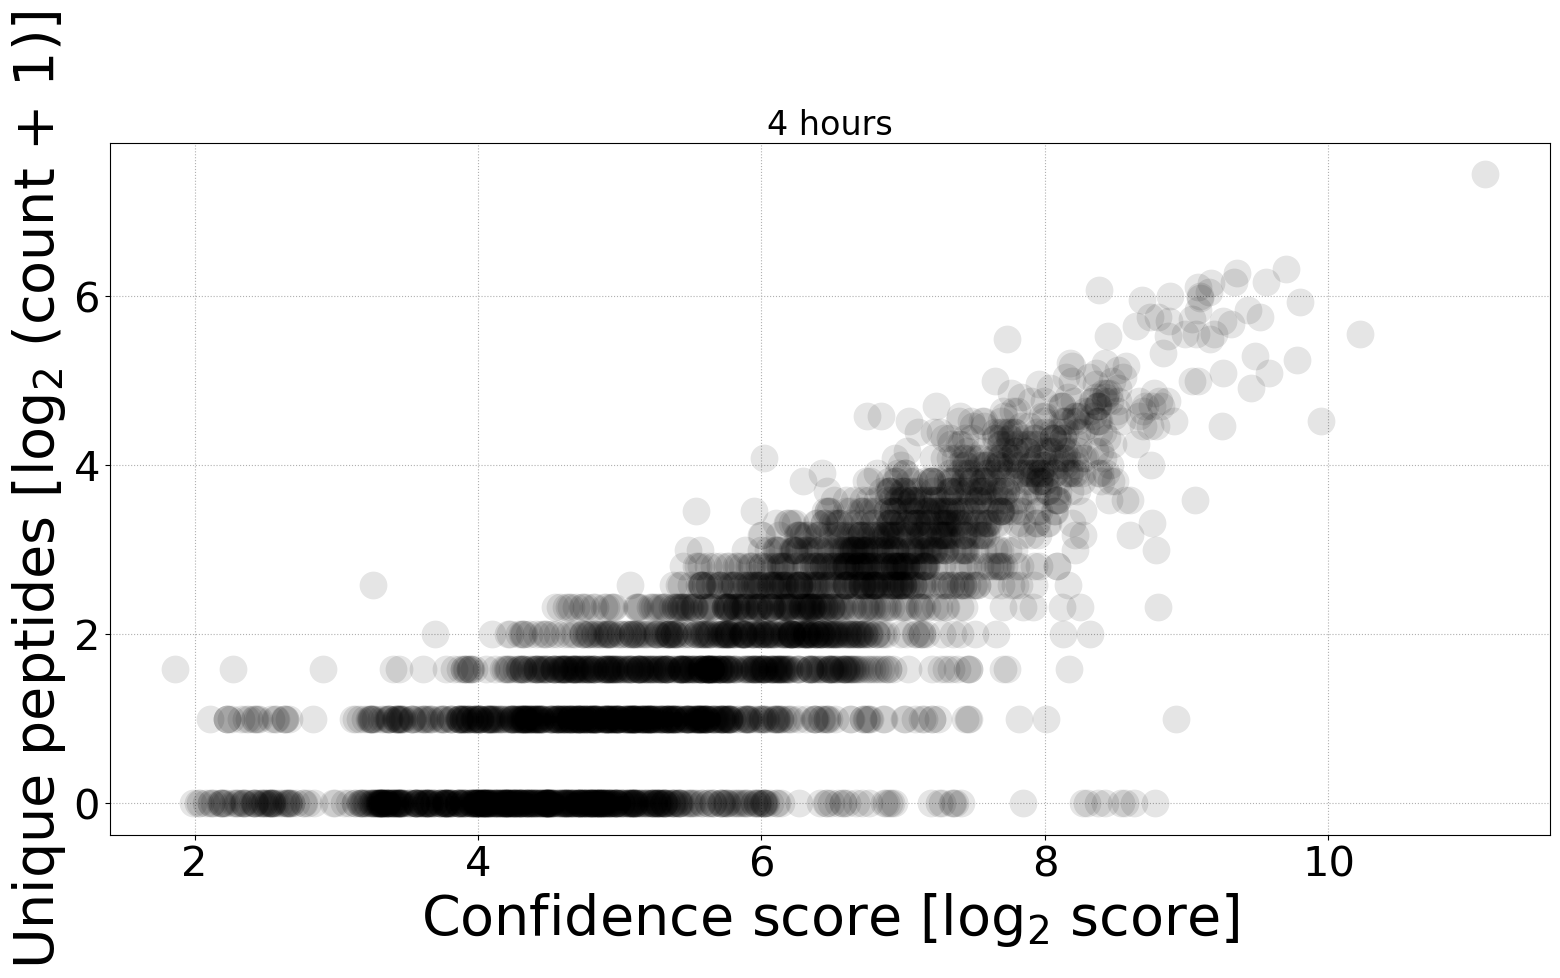

In [12]:
x = numpy.log2(df4['Confidence score'])
y = numpy.log2(df4['Unique peptides']+1)
               
matplotlib.pyplot.plot(x, y, 'o', color='black', alpha=1/10, markeredgecolor='None', ms=20)

matplotlib.pyplot.xlabel('Confidence score [log$_2$ score]')
matplotlib.pyplot.ylabel('Unique peptides [log$_2$ (count + 1)]')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.title('4 hours')
matplotlib.pyplot.tight_layout()

Arbitrary thresholds for confident identifications:
- X-axis: log2 CS = 7 which represents a 2\**7 = 128 score.
- Y-axis: log2 unique peptides + 1 = 3 which represents a 2\**(3)-1 = 7 unique peptides.

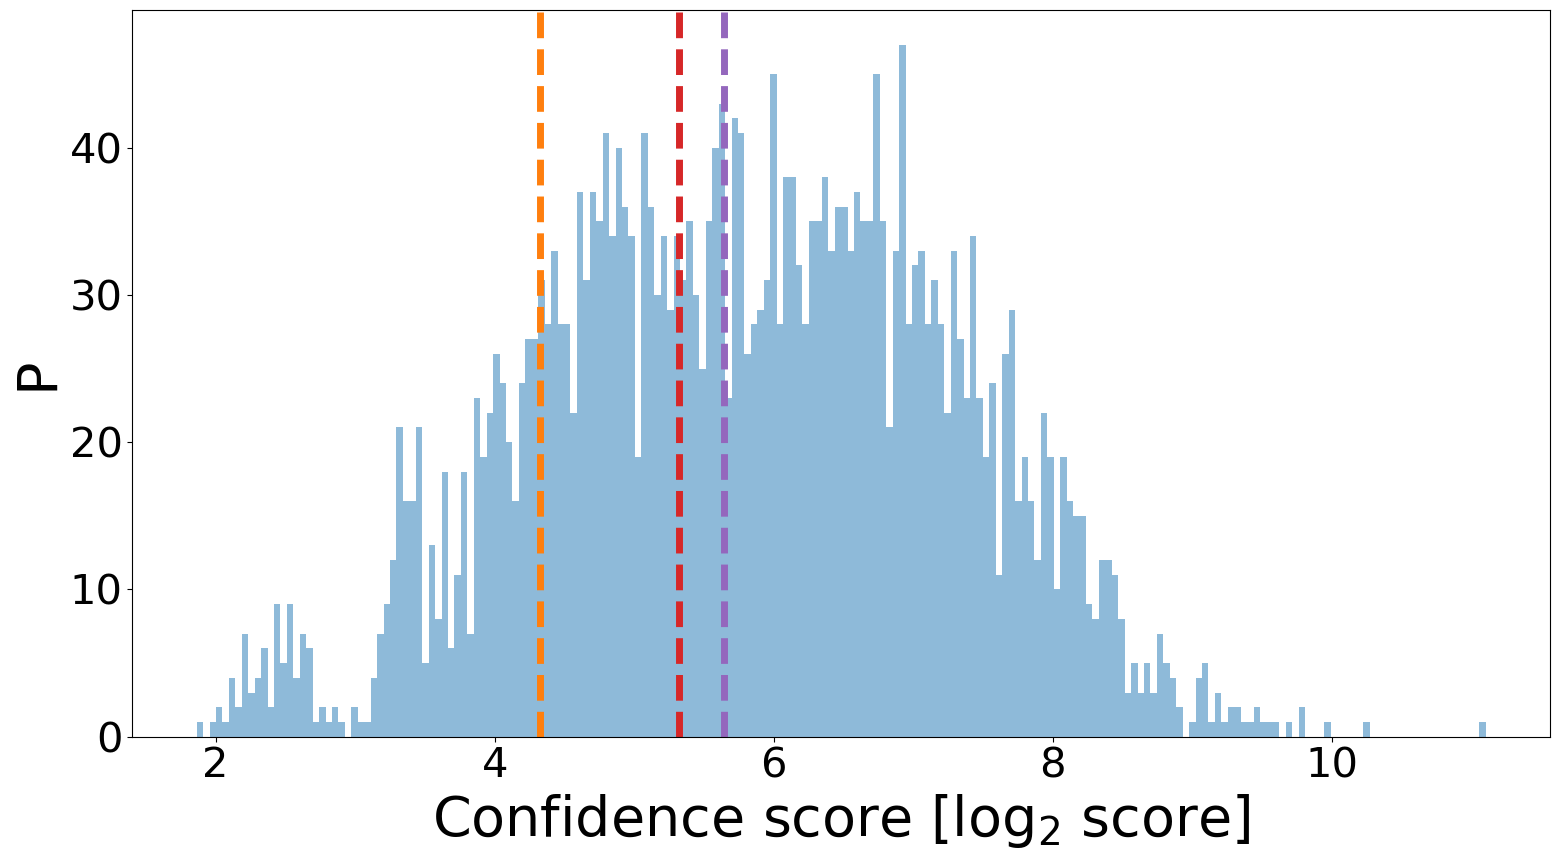

In [13]:
matplotlib.pyplot.hist(numpy.log2(df4['Confidence score']), bins=200, alpha=1/2)
matplotlib.pyplot.axvline(x=numpy.log2(20), lw=5, ls='--', color='tab:orange')
matplotlib.pyplot.axvline(x=numpy.log2(40), lw=5, ls='--', color='tab:red')
matplotlib.pyplot.axvline(x=numpy.log2(50), lw=5, ls='--', color='tab:purple')
matplotlib.pyplot.xlabel('Confidence score [log$_2$ score]')
matplotlib.pyplot.ylabel('P')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [14]:
new4 = df4[(df4['Unique peptides'] >= 3) & (df4['Confidence score'] >= 50)]
print(new4.shape)

working_labels = [label for label in new4.columns if label in all_sample_names]

new4 = numpy.log2(new4.loc[:, working_labels] + 1)
print(new4.shape)
new4

(1400, 85)
(1400, 24)


20220905_ARNAR_004  20220905_ARNAR_005  20220905_ARNAR_008  \
Accession                                                               
P07996              16.045552           16.078366           16.161570   
Q9BYC5               9.957537            9.846812            9.972054   
P17612              11.366183           11.371677           11.502530   
Q9NVA2              12.240767           12.273150           12.230812   
P09382              16.043690           16.115637           16.117788   
...                       ...                 ...                 ...   
P08240              11.285331           11.255580           10.993814   
Q15181              12.069411           12.079153           12.072432   
O94929              11.100895           11.061101           10.985095   
P11940              10.938910           10.909989           10.984745   
Q5T9S5              12.065849           12.090588           12.101302   

           20220905_ARNAR_009  20220905_ARNAR_051  20220905_ARNAR_052  \
Accession                                                               
P07996              16.156538           16.229749           16.211154   
Q9BYC5               9.924427            9.952922            9.961175   
P17612              11.458926           11.281645           11.490084   
Q9NVA2              12.246755           12.321591           12.283944   
P09382              16.162780           16.369342           16.357563   
...                       ...                 ...                 ...   
P08240              11.011575           11.726454           11.892376   
Q15181              12.126384           12.391033           12.391620   
O94929              10.966830           11.556627           11.706831   
P11940              10.975925           10.923703           10.957724   
Q5T9S5              12.134545           12.465226           12.474968   

           20220905_ARNAR_010  20220905_ARNAR_011  20220905_ARNAR_035  \
Accession                                                               
P07996              15.643942           15.675235           15.817460   
Q9BYC5              10.160242           10.292097           10.272115   
P17612              10.982659           11.018419           11.036613   
Q9NVA2              12.229056           12.302041           12.452724   
P09382              16.185005           16.186321           16.538914   
...                       ...                 ...                 ...   
P08240              11.074597           11.051692           11.468444   
Q15181              12.072226           12.071841           12.168879   
O94929              11.139484           11.076676           11.281246   
P11940              10.735809           10.728667           11.009232   
Q5T9S5              12.129535           12.233542           12.079865   

           20220905_ARNAR_036  ...  20220905_ARNAR_019  20220905_ARNAR_020  \
Accession                      ...                                           
P07996              15.806405  ...           16.285414           16.314586   
Q9BYC5              10.290766  ...            9.578374            9.437409   
P17612              11.051132  ...           11.340180           11.419755   
Q9NVA2              12.257791  ...           12.362618           12.350376   
P09382              16.523372  ...           16.308708           16.349512   
...                       ...  ...                 ...                 ...   
P08240              11.367476  ...           11.134844           11.174485   
Q15181              12.141165  ...           12.004368           12.028826   
O94929              11.196087  ...           11.226472           11.256388   
P11940              10.770036  ...           10.864331           10.930608   
Q5T9S5              11.996127  ...           12.173067           12.192364   

           20220905_ARNAR_044  20220905_ARNAR_046  20220905_ARNAR_024  \
Accession                                                               


### biomarkers analysis

In [15]:
detected_biomarkers = {}
for biomarker in biomarkers.keys():
    uniprot_id = biomarkers[biomarker]
    print('working with biomarker {}, uniprot {}'.format(biomarker, uniprot_id))
    for element in df4.index:
        if uniprot_id in element:
            print('\t{}, peptide count {}, score {}'.format(element, df4.loc[element, 'Unique peptides'], df4.loc[element, 'Confidence score']))
            detected_biomarkers[element] = biomarker

detected_biomarkers.keys()

working with biomarker endothelin, uniprot P05305
working with biomarker PAI-1, uniprot P05121
	P05121, peptide count 19, score 215.7082
working with biomarker uPA, uniprot P00749
working with biomarker VCAM-1, uniprot P19320
working with biomarker L-selectin, uniprot P14151
working with biomarker Ang2, uniprot O15123
working with biomarker VEGFr1, uniprot P17948
working with biomarker ICAM-2, uniprot P13598
	P13598, peptide count 4, score 73.0967
working with biomarker tie2, uniprot Q02763
working with biomarker IL-6, uniprot P05231
working with biomarker E-selectin, uniprot P16581
working with biomarker ICAM-1, uniprot P05362
	P05362, peptide count 2, score 38.8919
working with biomarker P-selectin, uniprot P16109
working with biomarker Ang1, uniprot Q15389
working with biomarker vWF, uniprot P04275
working with biomarker PDGF, uniprot P01127
working with biomarker endocan, uniprot Q9NQ30
working with biomarker TNFa, uniprot P01375
working with biomarker VEGFa, uniprot P15692


dict_keys(['P05121', 'P13598', 'P05362'])

(1725, 85)
(1725, 24)
P05121 4h control
P05121 4h epi
P05121 4h nor
P05121 4h epinor
P05121 4h TNFa
PAI-1 [16.3832417056705, 16.25073217723727, 16.05110504365731, 16.560087582443636, 15.911607289679079]
P13598 4h control
P13598 4h epi
P13598 4h nor
P13598 4h epinor
P13598 4h TNFa
ICAM-2 [11.30708491293669, 11.152889753244269, 11.283341130695469, 11.026727007720375, 11.427917779712786]
P05362 4h control
P05362 4h epi
P05362 4h nor
P05362 4h epinor
P05362 4h TNFa
ICAM-1 [8.997995631411488, 9.680851805483684, 9.821697572475937, 9.378187612041048, 10.413116187652733]
{'PAI-1': [0.0, -0.1325095284332285, -0.33213666201319114, 0.176845876773136, -0.47163441599142075], 'ICAM-2': [0.0, -0.1541951596924207, -0.023743782241220757, -0.28035790521631476, 0.12083286677609628], 'ICAM-1': [0.0, 0.6828561740721959, 0.8237019410644493, 0.3801919806295597, 1.415120556241245]}


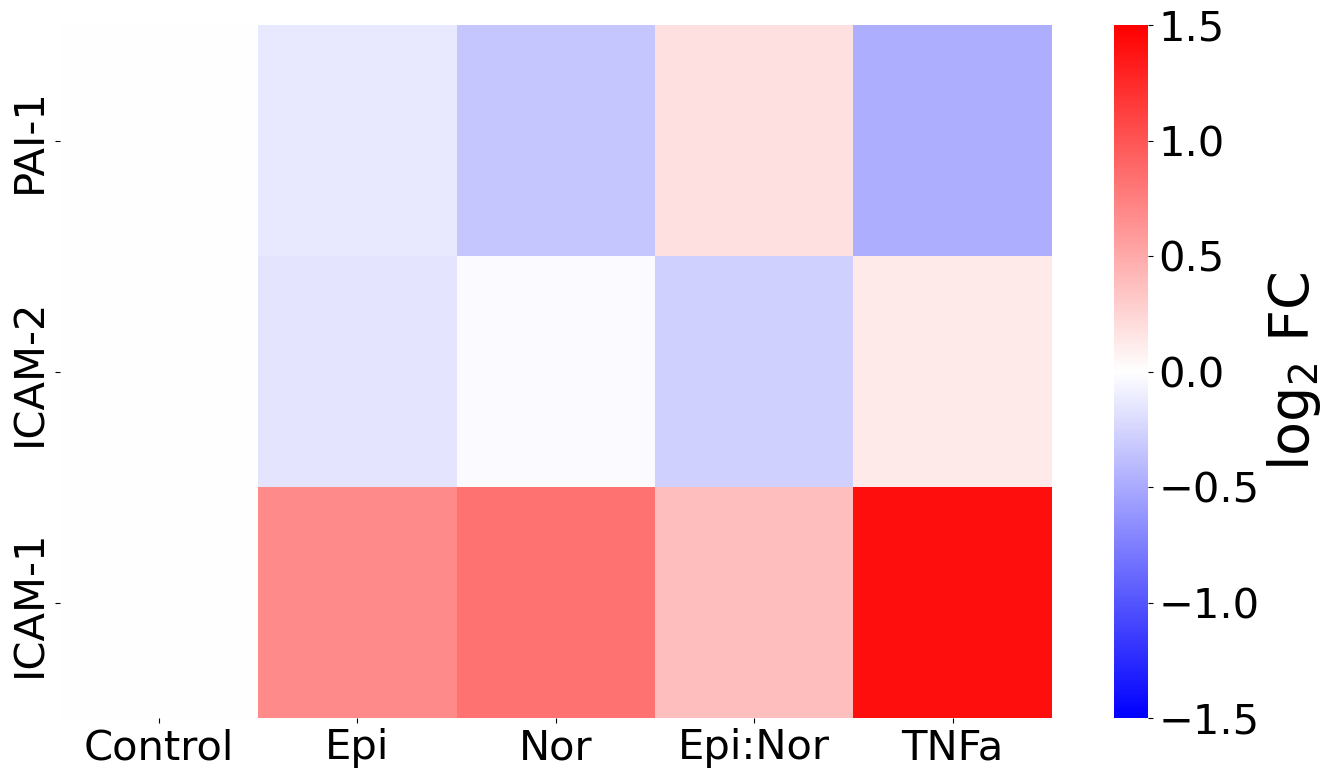

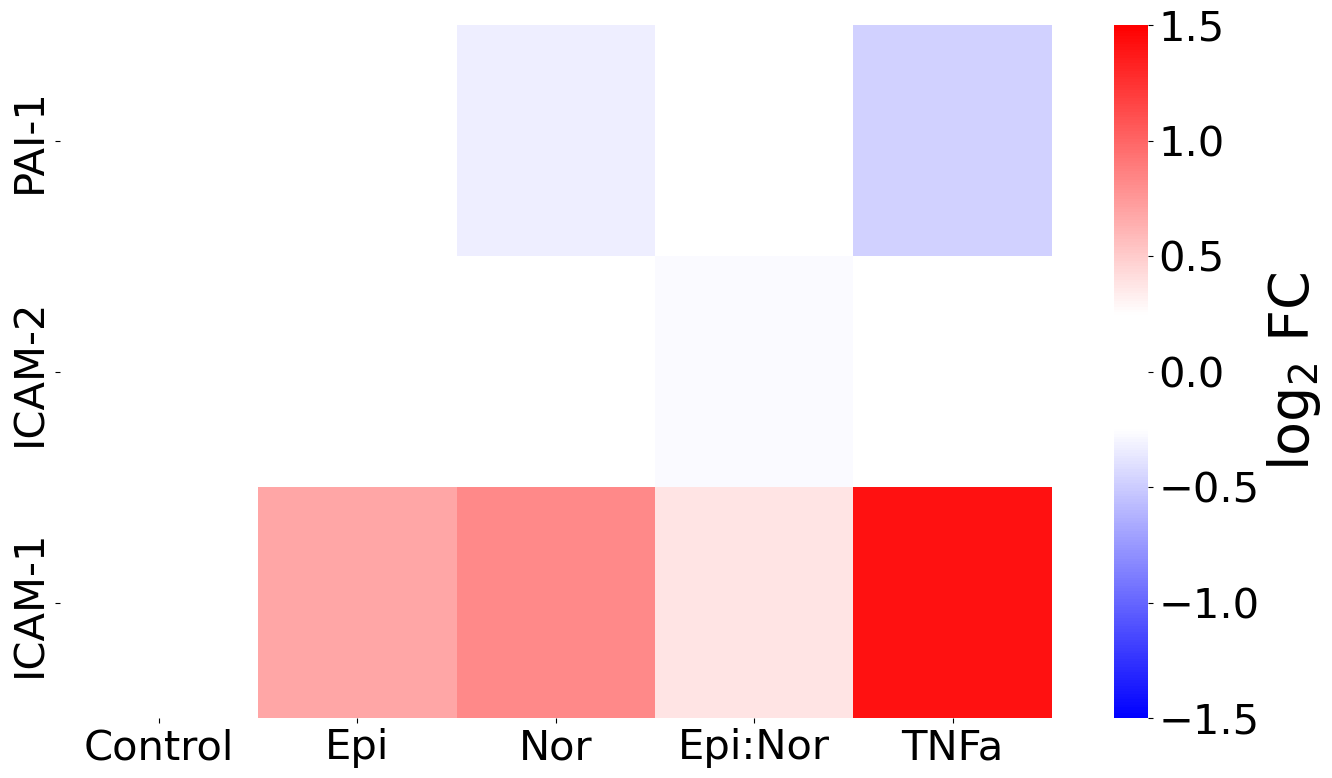

In [16]:
# P05362, peptide count 2, score 38.8919
biomarkers_df = df4[(df4['Unique peptides'] >= 2) & (df4['Confidence score'] >= 38)]
print(biomarkers_df.shape)
biomarkers_df = numpy.log2(biomarkers_df.loc[:, working_labels] + 1)
print(biomarkers_df.shape)

### normalization
# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(biomarkers_df.values, axis=0), index=biomarkers_df.index, columns=biomarkers_df.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qnbiodf = biomarkers_df.rank(method="min").stack().astype(int).map(df_mean).unstack()

# gererate data for heatmap
heatmap_data = {}
for marker in detected_biomarkers.keys():
    heatmap_data[detected_biomarkers[marker]] = []
    for treatment in metadata.keys():
        print(marker, treatment)
        log2_intensity = numpy.median(qnbiodf.loc[marker, metadata[treatment]].values)
        heatmap_data[detected_biomarkers[marker]].append(log2_intensity)
    print(detected_biomarkers[marker], heatmap_data[detected_biomarkers[marker]])

for biomarker in heatmap_data:
    reference = heatmap_data[biomarker][0]
    for i in range(len(heatmap_data[biomarker])):
        heatmap_data[biomarker][i] = heatmap_data[biomarker][i] - reference
print(heatmap_data)
heatmap_df = pandas.DataFrame.from_dict(heatmap_data).transpose()
heatmap_df.columns = ['Control', 'Epi', 'Nor', 'Epi:Nor', 'TNFa']

colors = [(0, "blue"), (0.5-(1/12), "white"), (0.5+(1/12), "white"), (1, "red")]
bwwr = matplotlib.colors.LinearSegmentedColormap.from_list("bwwr", colors)

seaborn.heatmap(data=heatmap_df, cmap='bwr', vmin=-1.5, vmax=1.5, cbar_kws={'label':'log$_2$ FC'})
matplotlib.pyplot.show()

seaborn.heatmap(data=heatmap_df, cmap=bwwr, vmin=-1.5, vmax=1.5, cbar_kws={'label':'log$_2$ FC'})
matplotlib.pyplot.show()

- PAI-1 is upregulated by adrenaline [https://pubmed.ncbi.nlm.nih.gov/11792849/]
- adrenaline at 10 and 100 μmol/l, but not at 1 μmol/l significantly increased the expression of E-selectin, Icam1 and Vcam1 on HUVEC [https://link.springer.com/article/10.1007/s00125-011-2141-5]

### visualize data

200
19.492541086884188


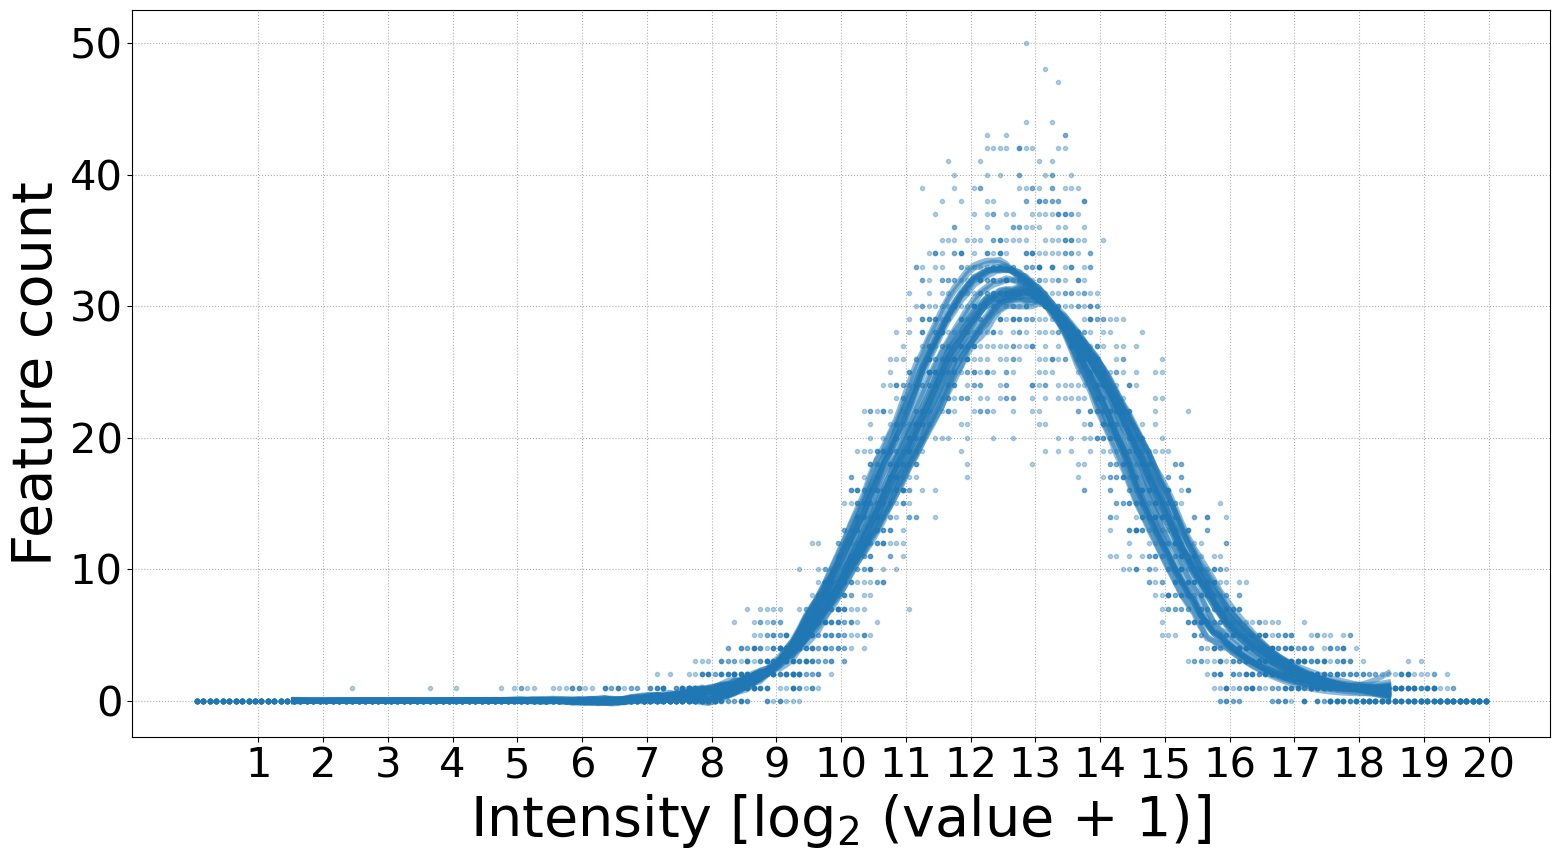

In [17]:
found_max = 20
number_of_bins = found_max * 10
margin = 15
print(number_of_bins)

absolute_max = 0
plotting_x = []; plotting_y = []
most_likely_early = []

for sample in new4.columns:
        
    intensities = new4.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(intensities, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # storing info to quantify bias
    most_likely_intensity = x[numpy.argmax(yhat)]
    most_likely_early.append(most_likely_intensity)
    
    
    # plotting
    the_color = 'tab:blue'
    matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color=the_color)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color=the_color)
    
    # check
    if max(intensities) > absolute_max:
        absolute_max = max(intensities)

# check print
print(absolute_max)

matplotlib.pyplot.xticks(range(1, 21))
matplotlib.pyplot.xlabel('Intensity [log$_2$ (value + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()

### normalization

In [18]:
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(new4.values, axis=0), index=new4.index, columns=new4.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = new4.rank(method="min").stack().astype(int).map(df_mean).unstack()

### distributions after normalization

200
19.071343768957153


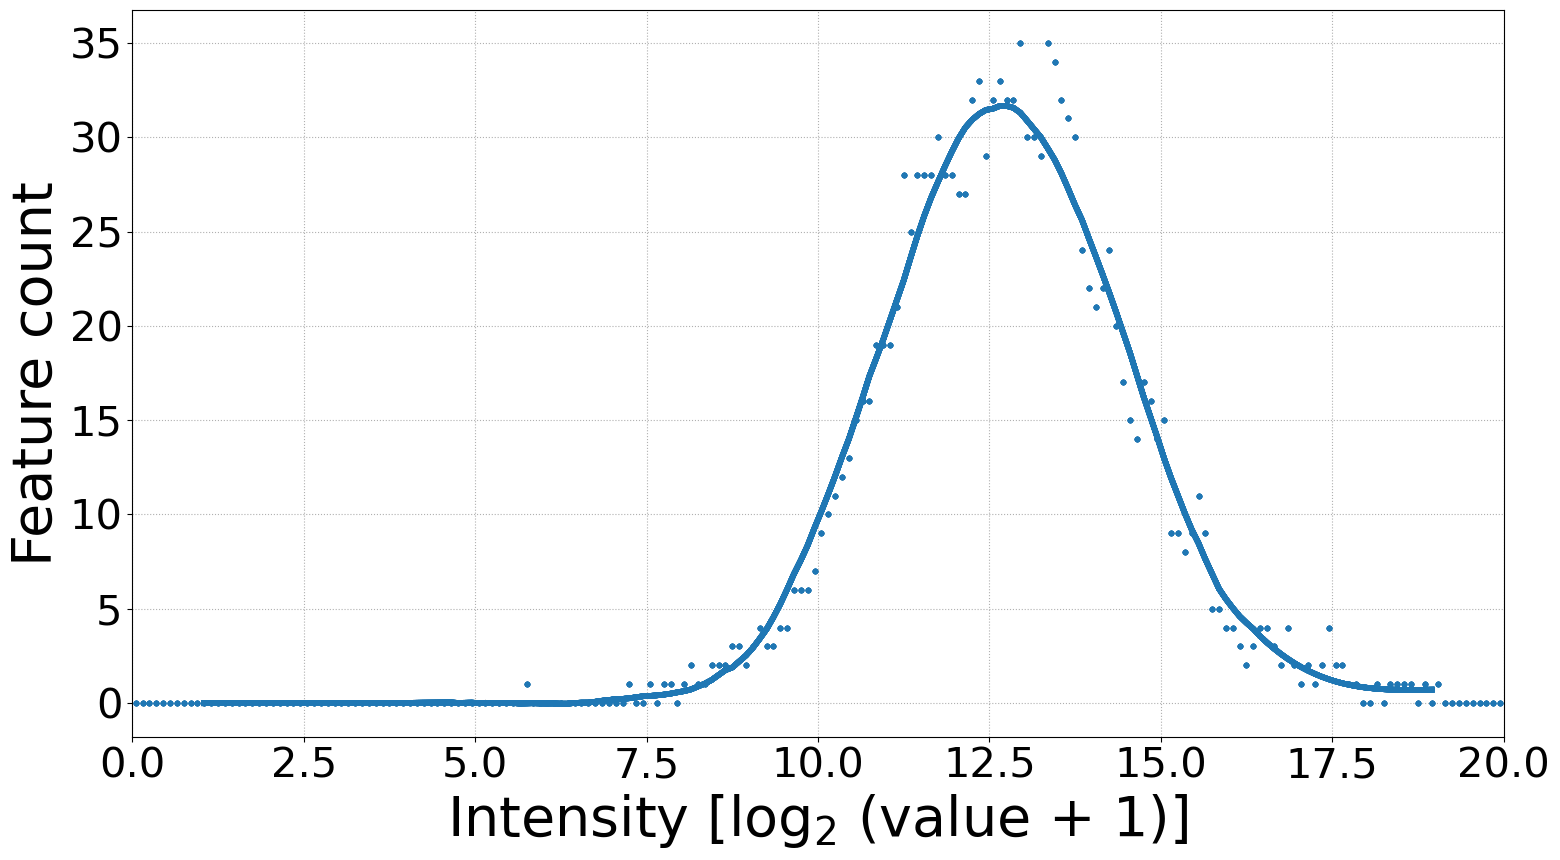

In [19]:
found_max = 20
number_of_bins = found_max * 10
margin = 10
print(number_of_bins)

absolute_max = 0
plotting_x = []; plotting_y = []
most_likely_early = []

for sample in qndf.columns:
        
    intensities = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(intensities, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # storing info to quantify bias
    most_likely_intensity = x[numpy.argmax(yhat)]
    most_likely_early.append(most_likely_intensity)
    
    
    # plotting
    the_color = 'tab:blue'
    matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color=the_color)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color=the_color)
    
    # check
    if max(intensities) > absolute_max:
        absolute_max = max(intensities)

# check print
print(absolute_max)
matplotlib.pyplot.xlim(0,20)

matplotlib.pyplot.xlabel('Intensity [log$_2$ (value + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()

### PCA

[0.31915297 0.15906583]


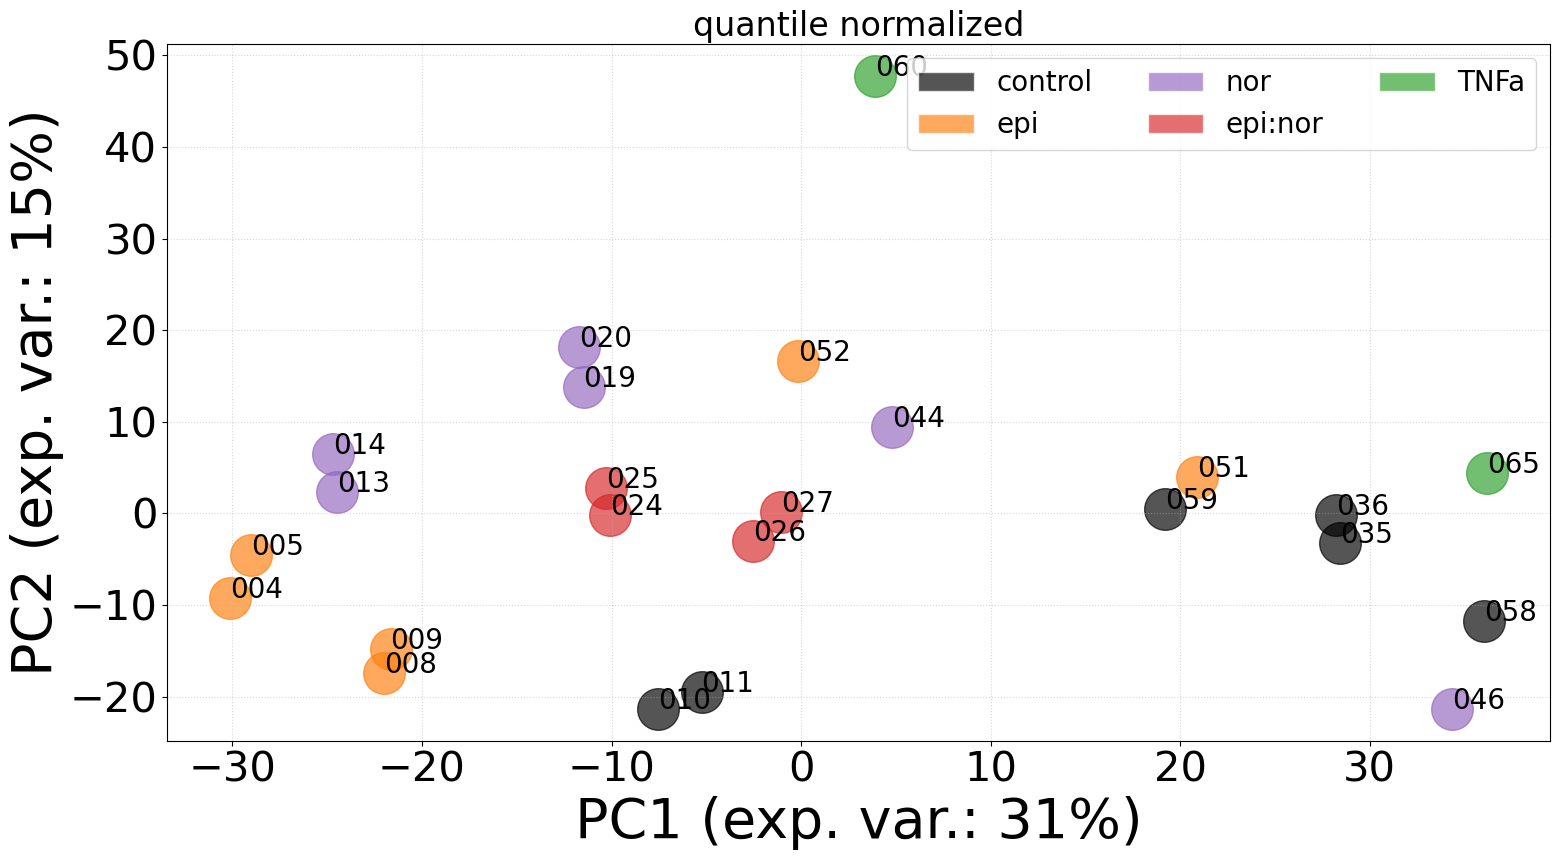

In [20]:
# quantile normalized all
transpose = qndf.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
        
    if qndf.columns[i] in metadata['4h control']:
        the_color = 'black'
    elif qndf.columns[i] in metadata['4h epi']:
        the_color = 'tab:orange'
    elif qndf.columns[i] in metadata['4h nor']:
        the_color = 'tab:purple'
    elif qndf.columns[i] in metadata['4h epinor']:
        the_color = 'tab:red'
    elif qndf.columns[i] in metadata['4h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
    
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    
    the_label = qndf.columns[i].split('_')[-1]
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label)
    
legend_elements = [ 
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('quantile normalized')
matplotlib.pyplot.tight_layout()

[0.54971548 0.11732986]


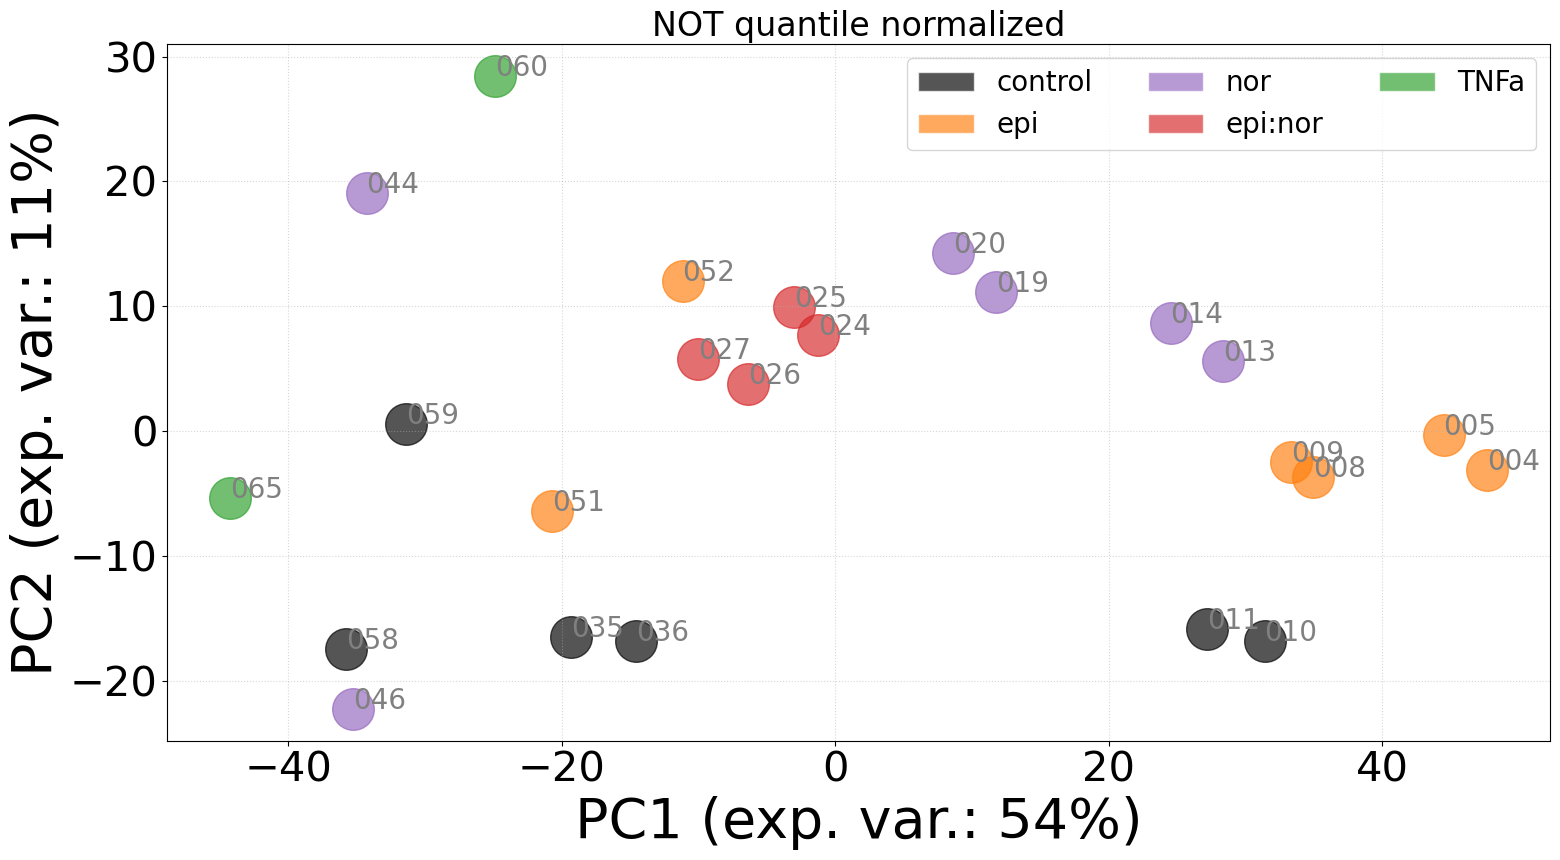

In [21]:
# non-quantile normalized all
transpose = new4.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
        
    if qndf.columns[i] in metadata['4h control']:
        the_color = 'black'
    elif qndf.columns[i] in metadata['4h epi']:
        the_color = 'tab:orange'
    elif qndf.columns[i] in metadata['4h nor']:
        the_color = 'tab:purple'
    elif qndf.columns[i] in metadata['4h epinor']:
        the_color = 'tab:red'
    elif qndf.columns[i] in metadata['4h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
        
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    
    the_label = new4.columns[i].split('_')[-1]
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label, color='gray')
    
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('NOT quantile normalized')

matplotlib.pyplot.tight_layout()

10
['20220905_ARNAR_060', '20220905_ARNAR_065', '20220905_ARNAR_052', '20220905_ARNAR_044', '20220905_ARNAR_051', '20220905_ARNAR_059', '20220905_ARNAR_036', '20220905_ARNAR_035', '20220905_ARNAR_058', '20220905_ARNAR_046']
[0.27369339 0.23548323]


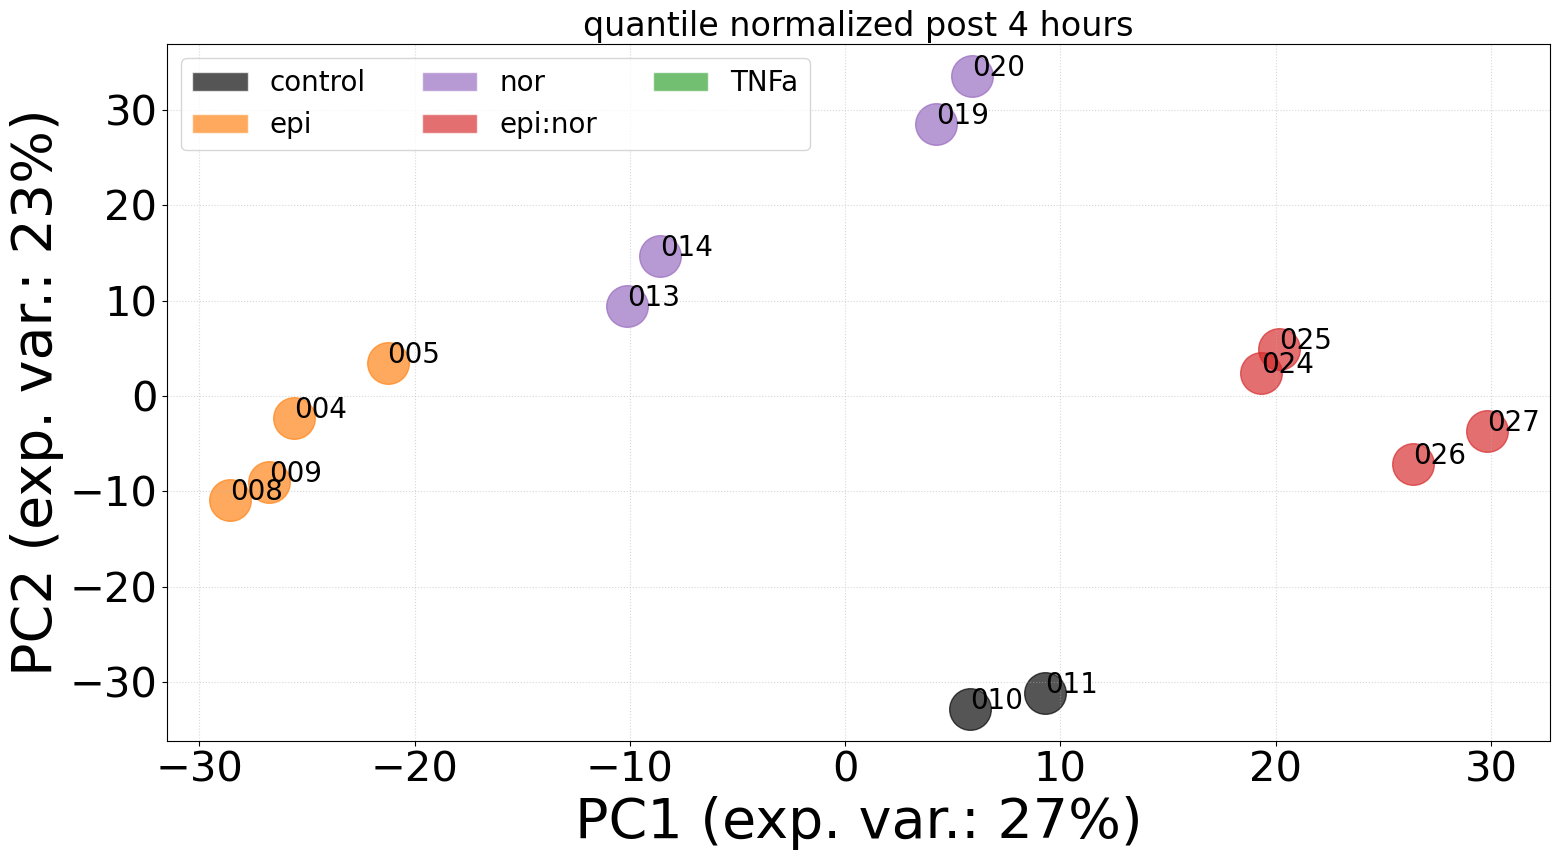

In [22]:
# excluding arbitrary samples
excluded_sample_tags = ['060', '065', '052', '044', '051', '059', '036', '035', '058', '046']
print(len(excluded_sample_tags)) # should be 10
excluded_samples = ['20220905_ARNAR_' + element for element in excluded_sample_tags]
print(excluded_samples)
simplified_df = new4.drop(excluded_samples, axis=1)

# normalization
# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(simplified_df.values, axis=0), index=simplified_df.index, columns=simplified_df.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = simplified_df.rank(method="min").stack().astype(int).map(df_mean).unstack()

# PCA
transpose = qndf.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
    the_label = qndf.columns[i].split('_')[-1]
        
    if simplified_df.columns[i] in metadata['4h control']:
        the_color = 'black'
    elif simplified_df.columns[i] in metadata['4h epi']:
        the_color = 'tab:orange'
    elif simplified_df.columns[i] in metadata['4h nor']:
        the_color = 'tab:purple'
    elif simplified_df.columns[i] in metadata['4h epinor']:
        the_color = 'tab:red'
    elif simplified_df.columns[i] in metadata['4h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
    
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label)
    
    
legend_elements = [ 
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('quantile normalized post 4 hours')
matplotlib.pyplot.tight_layout()

### make comparisons

In [23]:
def comparison_function(detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples):
    
    # f.1. determine P values
    fold_changes = []; pvalues = []

    for protein in qndf.index:
        control_values = qndf.loc[protein, control_samples].values
        treated_values = qndf.loc[protein, treated_samples].values

        log2FC = numpy.median(treated_values) - numpy.median(control_values)
        statistic, pvalue = scipy.stats.ttest_ind(control_values, treated_values)
        # dealing with exact same values on two samples
        if numpy.isnan(pvalue):
            pvalue = 1
        fold_changes.append(log2FC); pvalues.append(pvalue)

    print('P before correction', numpy.min(pvalues), numpy.max(pvalues))
    
    # f.2. Bonferroni correction
    significance_threshold = -numpy.log10(0.05/qndf.shape[0])
    a = numpy.array(pvalues)
    epsilon = -numpy.log10(numpy.min(a[a.nonzero()])/2)
    print(epsilon)

    plotting_p = []
    for element in pvalues:
        if element  == 0:
            plotting_p.append(epsilon)
        else:
            plotting_p.append(-numpy.log10(element))

    matplotlib.pyplot.plot(fold_changes, plotting_p, 'o', color='black', alpha=1/3, mec='None', ms=15)
    matplotlib.pyplot.axhline(y=significance_threshold, ls='--', lw=2, color='black', alpha=0.5)
    matplotlib.pyplot.ylabel('-log$_{10}$ P')
    matplotlib.pyplot.xlabel('log$_2$ FC')
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title('{} Bonferroni'.format(treatment_label))
    top = numpy.max(numpy.abs(fold_changes))
    print('max fold change', top)
    matplotlib.pyplot.xlim([-3, 3])
    
    matplotlib.pyplot.show()
    
    # f.3. Benjamini-Hochberg
    print('Benjamini-Hochberg correction')
    correction_model = statsmodels.stats.multitest.multipletests(pvalues, method='fdr_bh', alpha=0.1)
    a = numpy.array(correction_model[1])
    epsilon = -numpy.log10(numpy.min(a[a.nonzero()])/2)
    print('epsilon: {}'.format(epsilon))

    responding_proteins = []
    for i in range(len(correction_model[0])):

        # dealing with numerical value
        if correction_model[1][i] == 0:
            plotting_p = epsilon
        else:
            plotting_p = -numpy.log10(correction_model[1][i])

        # dealing with color
        if correction_model[0][i] == True and numpy.abs(fold_changes[i]) >= numpy.log2(1.25):
            plotting_color = treatment_color
            protein_id = qndf.index[i]
            description = rosetta[protein_id]
            responding_proteins.append(protein_id)
            print('\t {} {} [{:.2f}, {:.2f}]'.format(protein_id, description, fold_changes[i], plotting_p))
        else:
            plotting_color = 'black'

        # plot
        recalc = fold_changes[i]
        if recalc > 1.4:
            recalc = 1.4
        if recalc < -1.4:
            recalc = -1.4
    
        matplotlib.pyplot.plot(recalc, plotting_p, 'o', color=plotting_color, alpha=1/3, mec='None', ms=15)
        
        # dealing with biomarkers
        if qndf.index[i] in detected_biomarkers.keys():
            print(qndf.index[i], detected_biomarkers[qndf.index[i]], int(((2**recalc)*100)-100), plotting_p, plotting_color)

    matplotlib.pyplot.ylabel('-log$_{10}$ Q')
    matplotlib.pyplot.xlabel('log$_2$ FC')
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title('{} Benjamini-Hochberg'.format(treatment_label))
    matplotlib.pyplot.xlim([-1.5, 1.5])
    matplotlib.pyplot.show()

    print('{} proteins respond to treatment'.format(len(responding_proteins)))
    
    # plot three random responding proteins
    for protein in responding_proteins[:3]:
        control_values = qndf.loc[protein, control_samples].values
        treated_values = qndf.loc[protein, treated_samples].values

        d = {'Control':control_values, treatment_label:treated_values}
        container = pandas.DataFrame(dict([(k, pandas.Series(v)) for k, v in d.items()]))

        my_colors = ["white", treatment_color]
        seaborn.set_palette(my_colors)
        seaborn.boxplot(data=container)

        matplotlib.pyplot.title('{} {}'.format(protein, rosetta[protein]))
        matplotlib.pyplot.ylabel('log$_2$ Intensity')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        matplotlib.pyplot.show()
    
    return responding_proteins

P before correction 0.0 1.0
6.0795646064249755
max fold change 1.5297894491017239


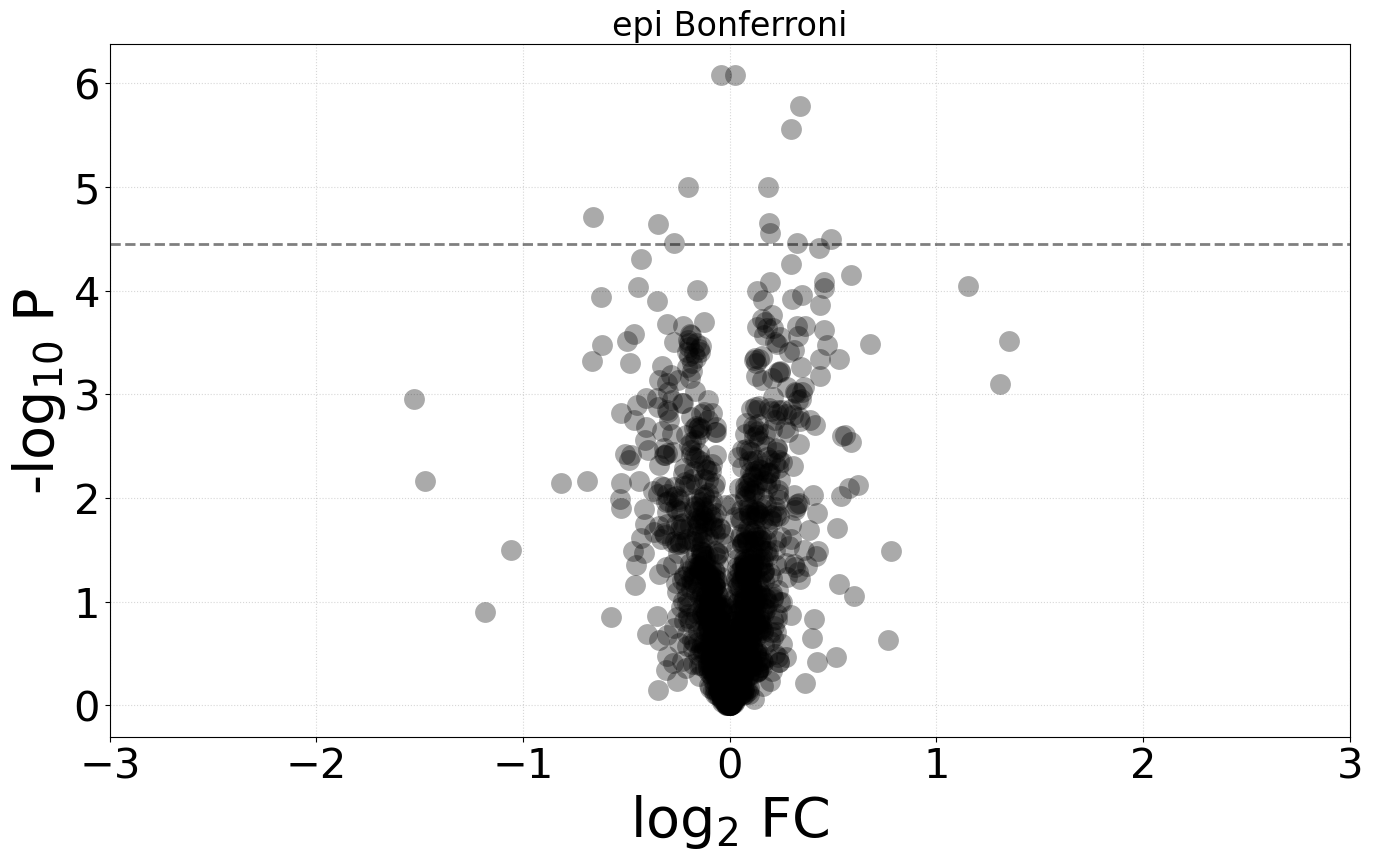

Benjamini-Hochberg correction
epsilon: 3.4105578254664
	 P07996 Thrombospondin-1 [0.45, 2.23]
	 P17612 cAMP-dependent protein kinase catalytic subunit alpha [0.46, 2.10]
	 Q9P035 Very-long-chain (3R)-3-hydroxyacyl-CoA dehydratase 3 [0.53, 2.06]
	 Q15746 Myosin light chain kinase_ smooth muscle [0.35, 1.88]
	 P29966 Myristoylated alanine-rich C-kinase substrate [0.68, 2.10]
	 Q5JSZ5 Protein PRRC2B [0.40, 1.32]
	 P67809;Q9Y2T7 Y-box-binding protein 1 [0.56, 1.68]
	 P01889 HLA class I histocompatibility antigen_ B alpha chain [1.35, 2.10]
	 Q9UHG3 Prenylcysteine oxidase 1 [0.34, 1.84]
	 Q86T65 Disheveled-associated activator of morphogenesis 2 [1.15, 2.23]
	 Q96NW4 Ankyrin repeat domain-containing protein 27 [0.33, 1.62]
	 Q14192 Four and a half LIM domains protein 2 [-0.52, 1.39]
	 P56537 Eukaryotic translation initiation factor 6 [-0.34, 1.14]
	 Q92626 Peroxidasin homolog [0.47, 2.10]
	 P22570 NADPH:adrenodoxin oxidoreductase_ mitochondrial [-0.62, 2.10]
	 Q5EBL4 RILP-like protein 1 [1.

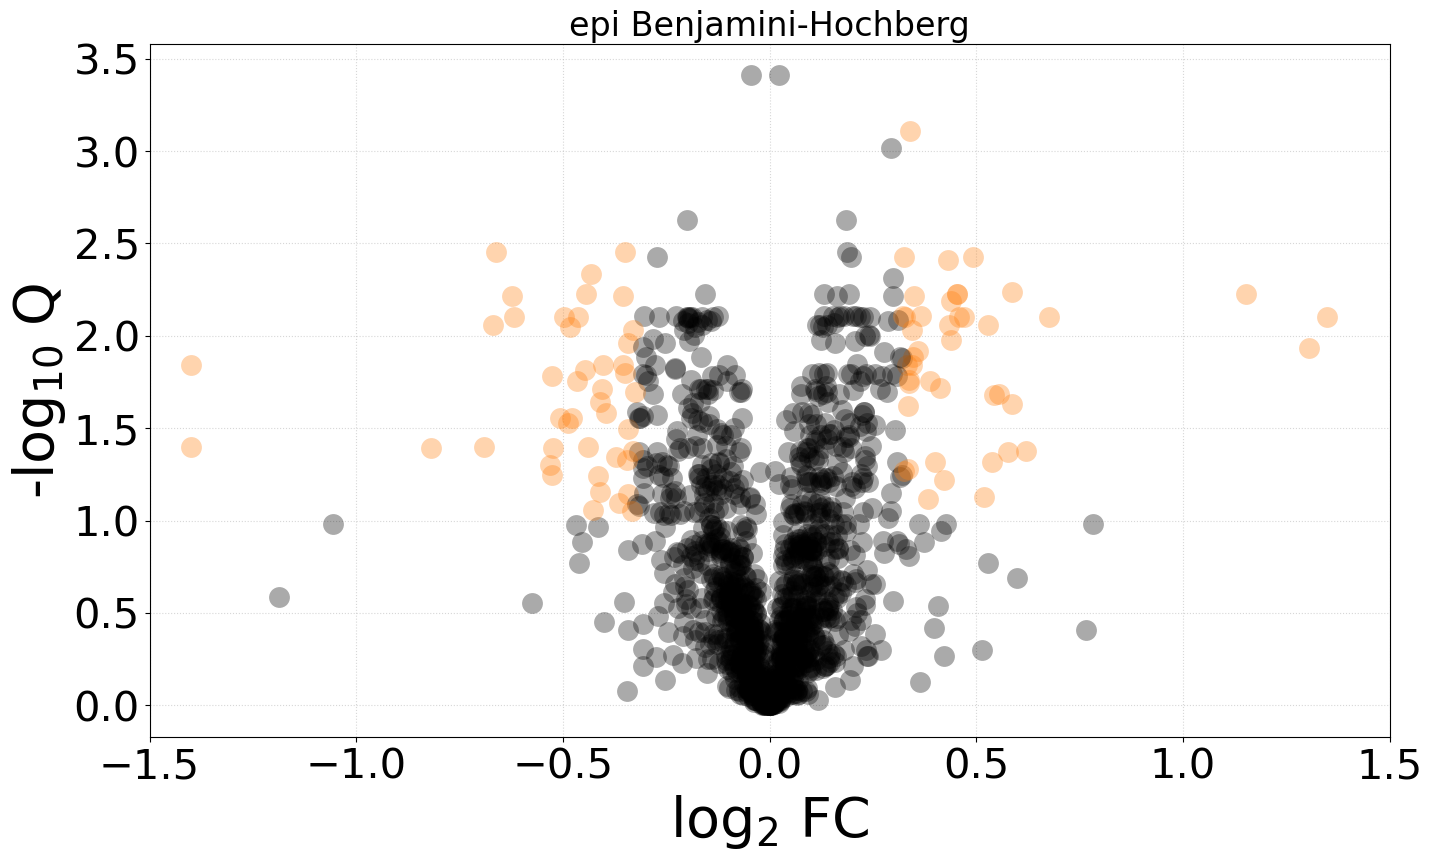

87 proteins respond to treatment


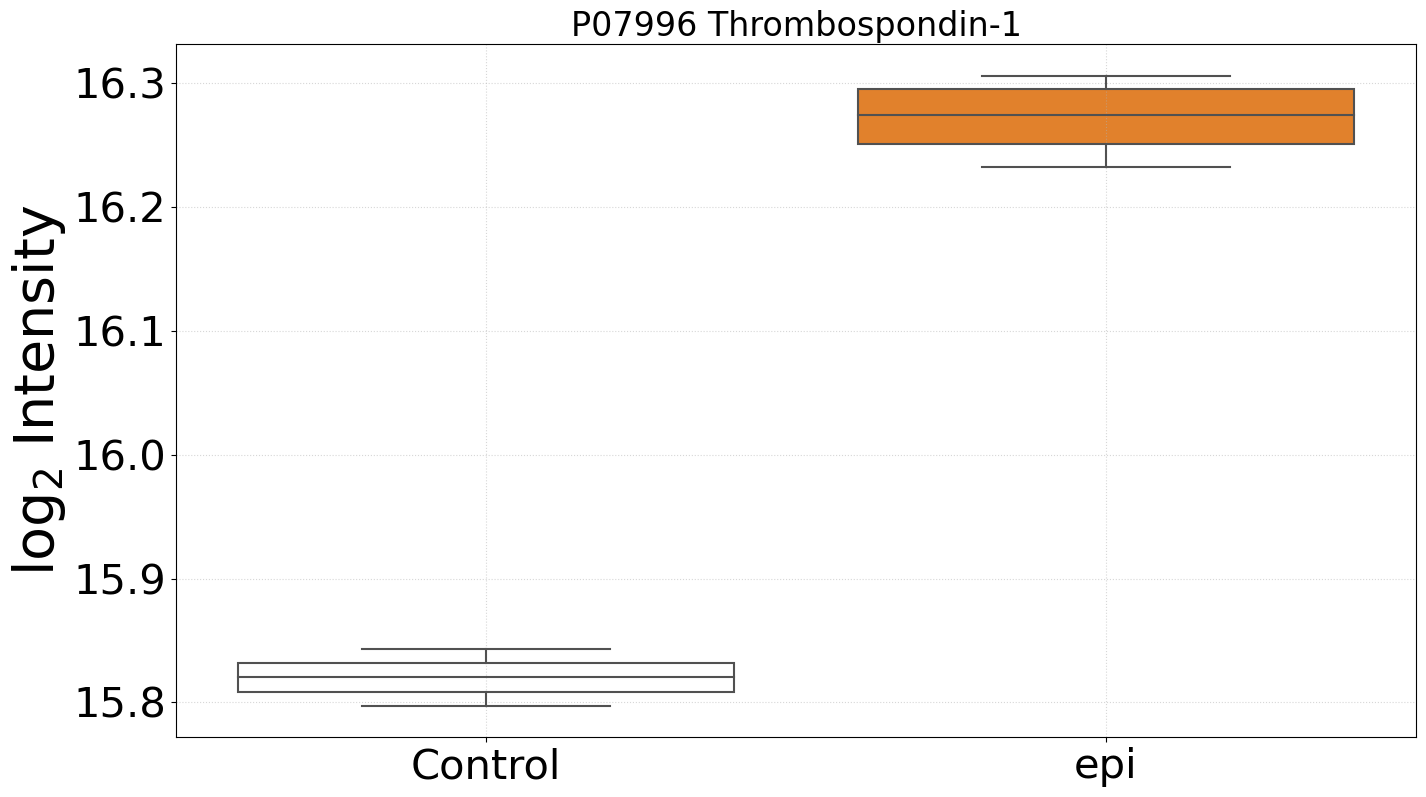

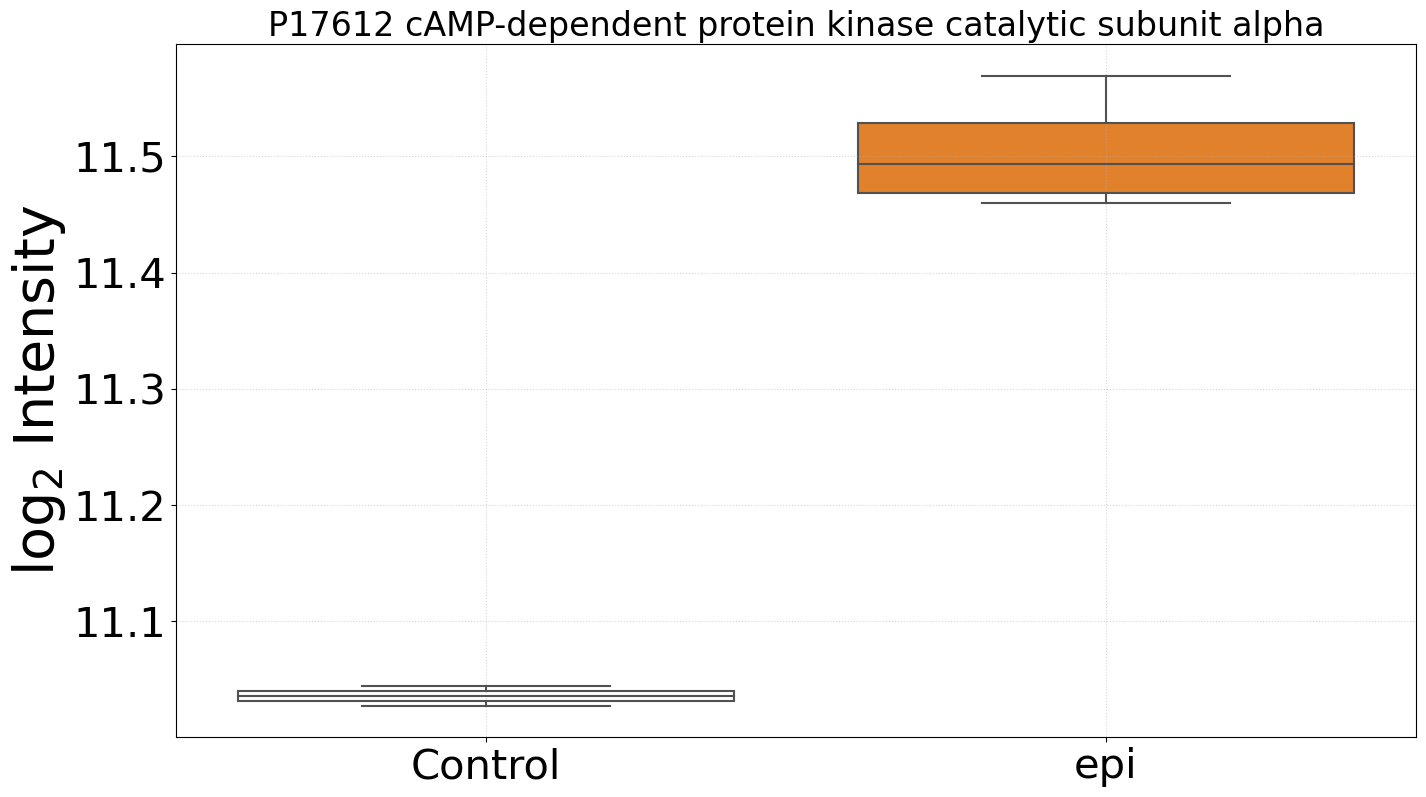

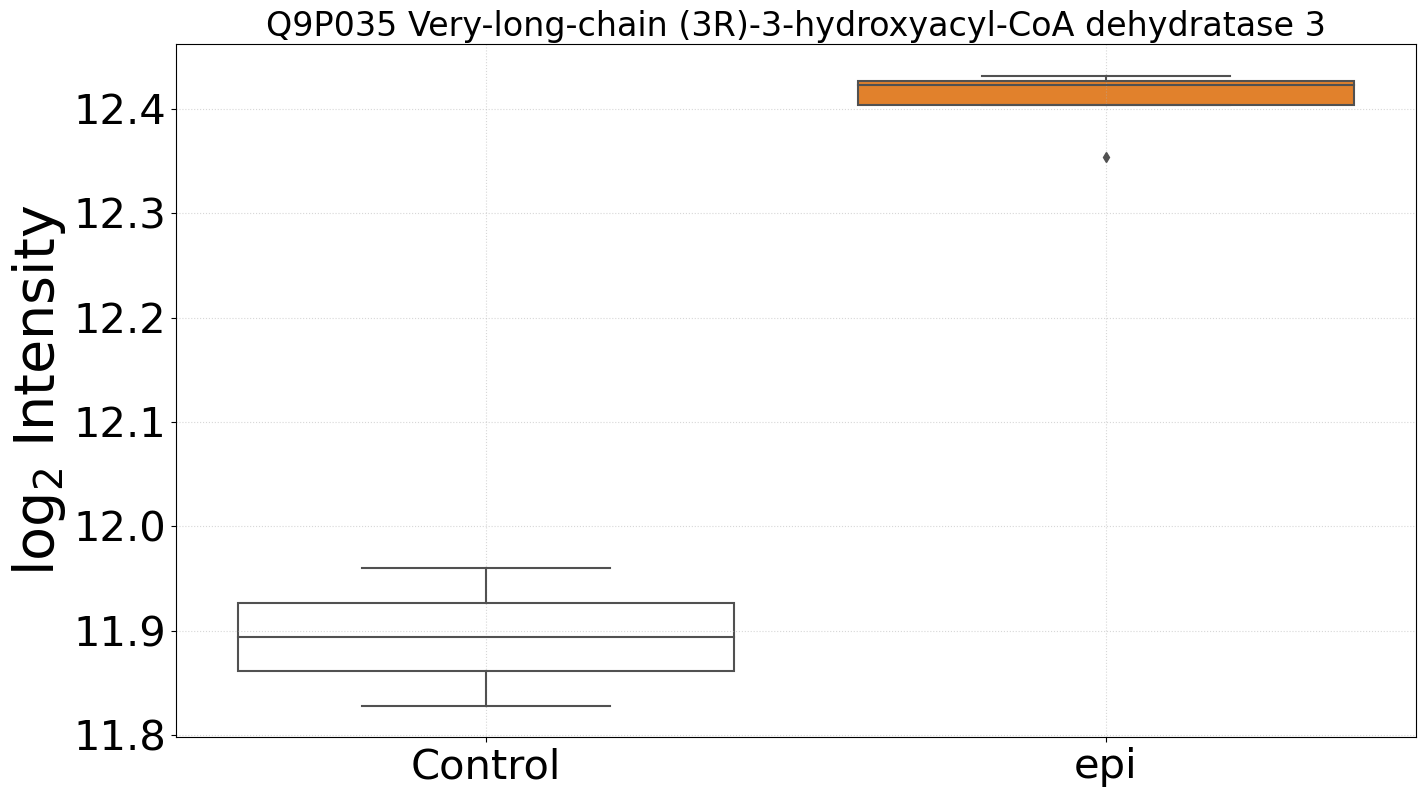

In [24]:
treatment_label = 'epi'
treatment_color = 'tab:orange'
control_samples = ['20220905_ARNAR_' + element for element in ['010', '011']]
treated_samples = ['20220905_ARNAR_' + element for element in ['005', '004', '009', '008']]
epi_response = comparison_function(detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

P before correction 0.0 1.0
5.684666918313519
max fold change 1.6866636140769682


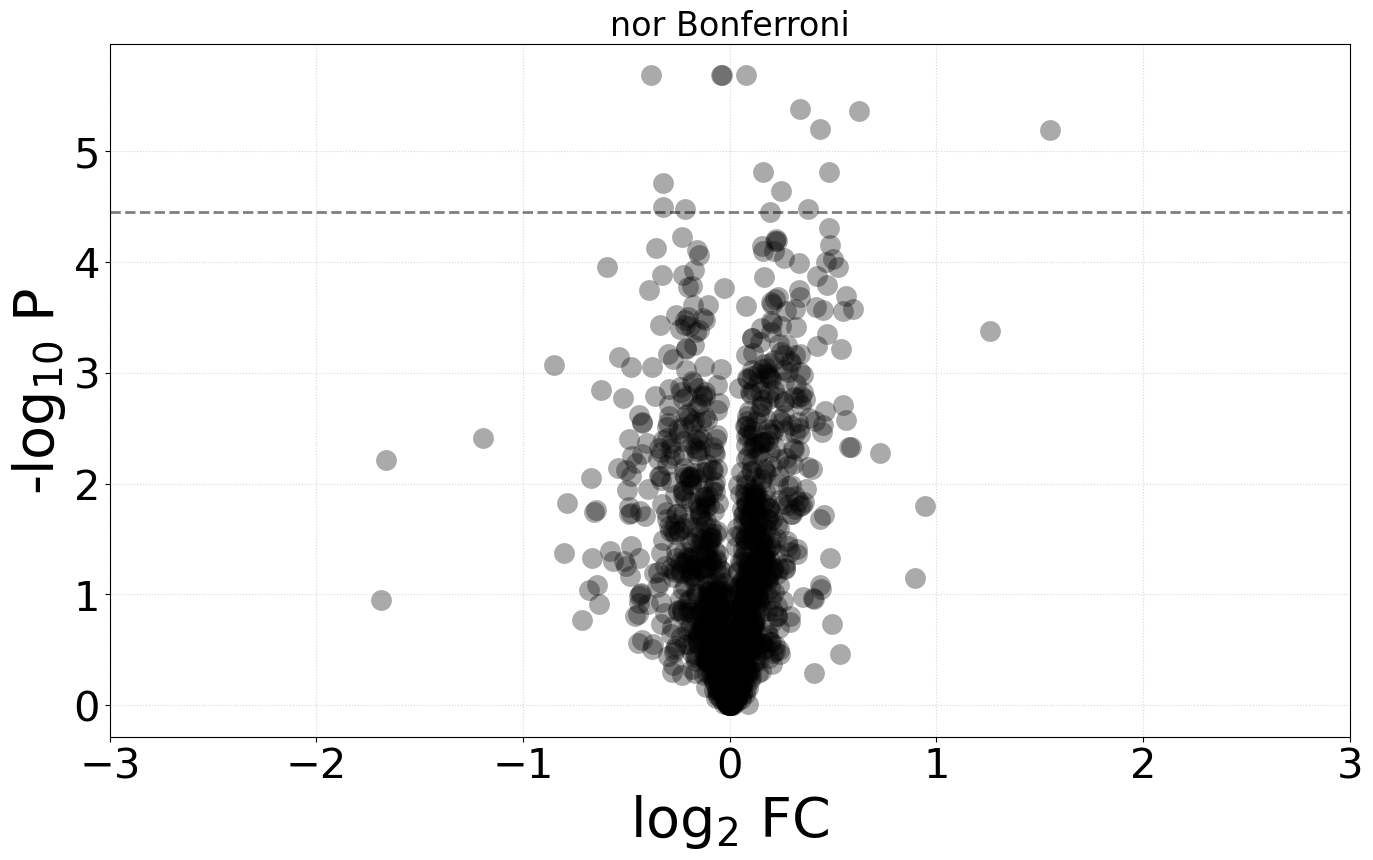

Benjamini-Hochberg correction
epsilon: 3.2913505238576706
	 P07996 Thrombospondin-1 [0.44, 2.94]
	 Q9BYC5 Alpha-(1_6)-fucosyltransferase [-0.62, 1.84]
	 P54762 Ephrin type-B receptor 1 [0.47, 2.25]
	 Q9P035 Very-long-chain (3R)-3-hydroxyacyl-CoA dehydratase 3 [0.36, 1.24]
	 Q5M9N0 Coiled-coil domain-containing protein 158 [0.33, 1.70]
	 P29966 Myristoylated alanine-rich C-kinase substrate [0.45, 1.68]
	 P67809;Q9Y2T7 Y-box-binding protein 1 [0.38, 1.45]
	 P01889 HLA class I histocompatibility antigen_ B alpha chain [1.55, 2.94]
	 Q86T65 Disheveled-associated activator of morphogenesis 2 [0.94, 1.23]
	 P61160 Actin-related protein 2 [0.34, 2.35]
	 Q9Y5X1 Sorting nexin-9 [0.59, 2.19]
	 Q9NVJ2;Q96BM9 ADP-ribosylation factor-like protein 8B [-0.33, 1.55]
	 Q2TAC2 Coiled-coil domain-containing protein 57 [0.34, 2.99]
	 Q92626 Peroxidasin homolog [0.33, 1.67]
	 P22570 NADPH:adrenodoxin oxidoreductase_ mitochondrial [-0.85, 1.94]
	 Q5JSL3 Dedicator of cytokinesis protein 11 [-0.33, 1.23]
	 Q8

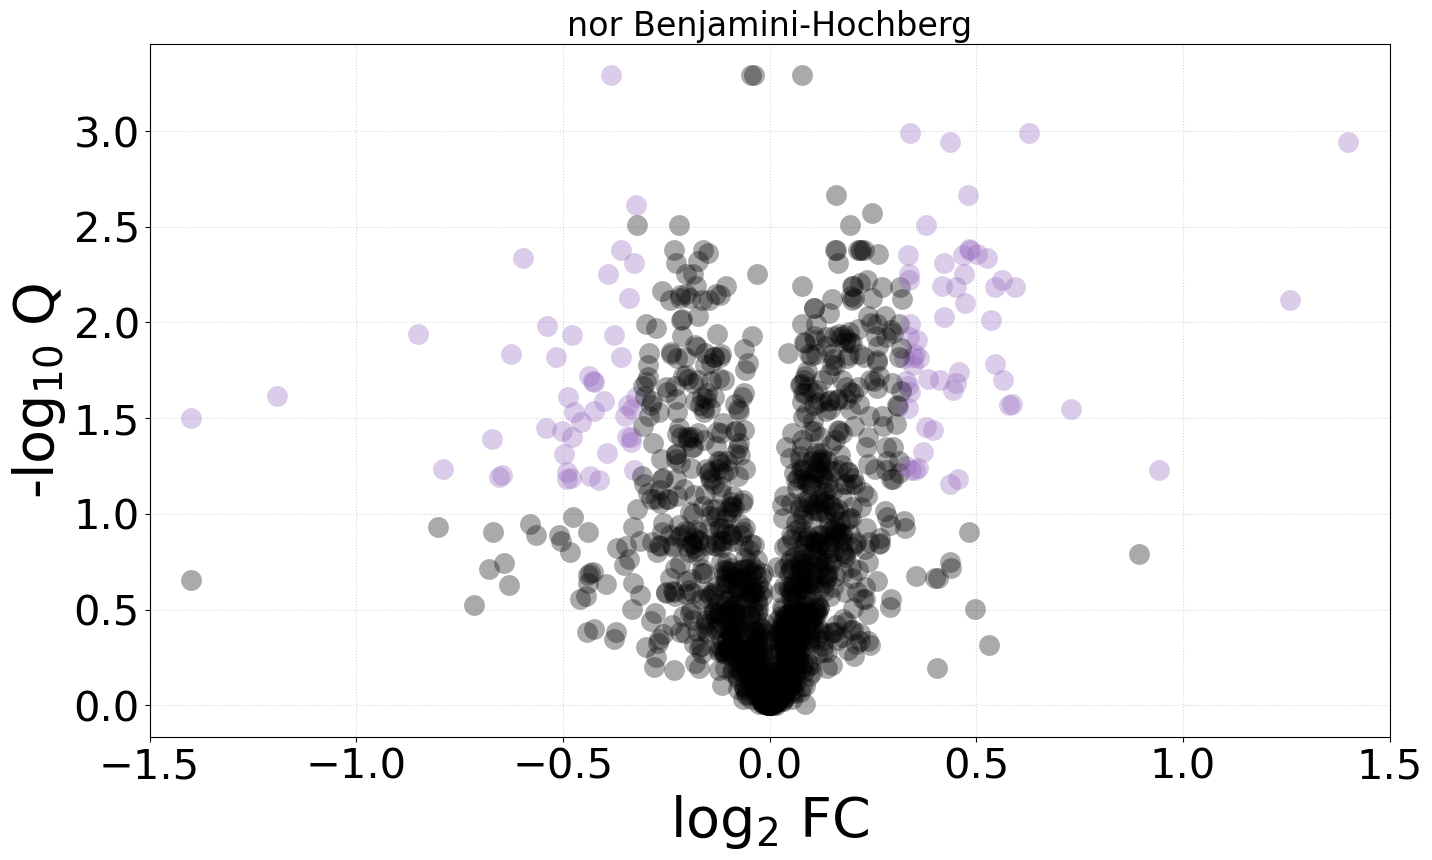

103 proteins respond to treatment


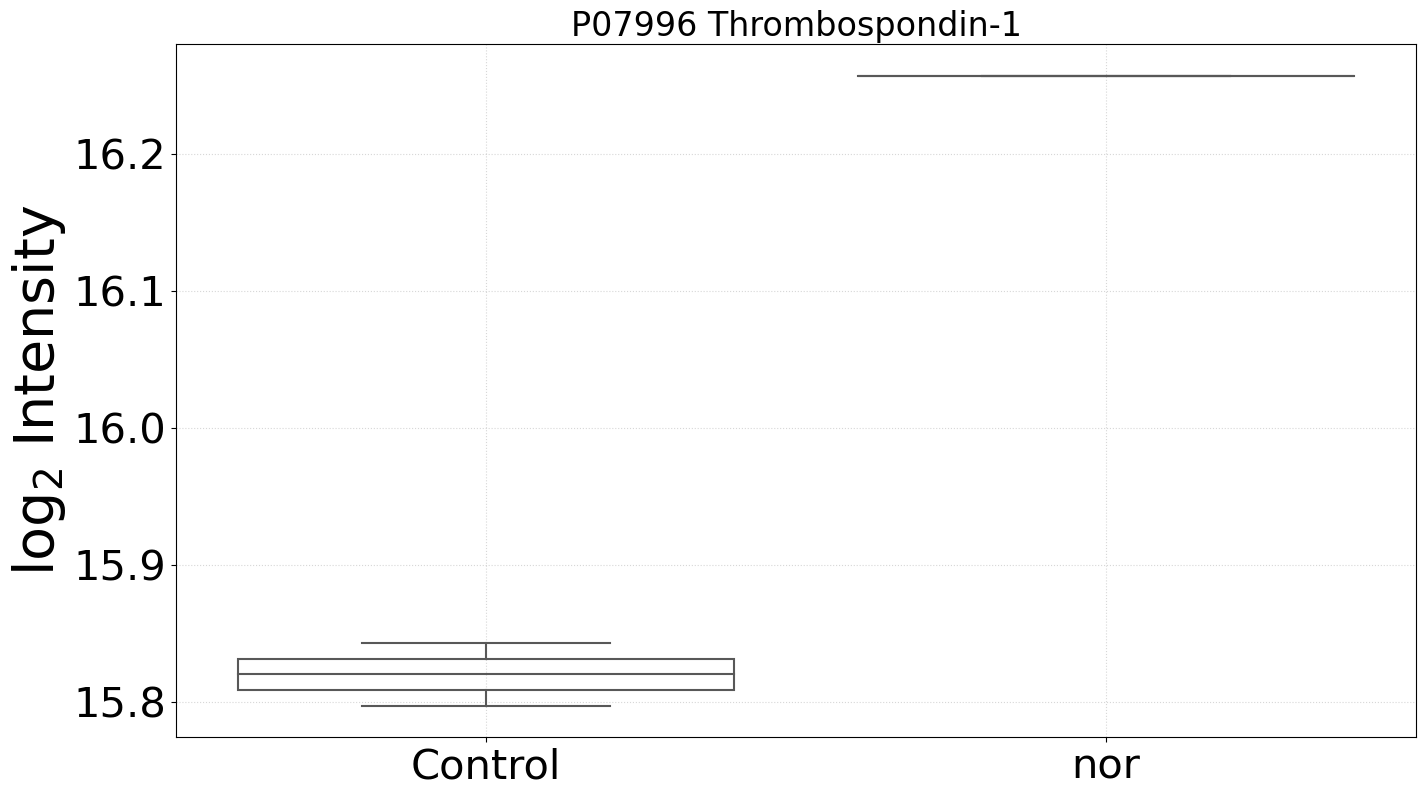

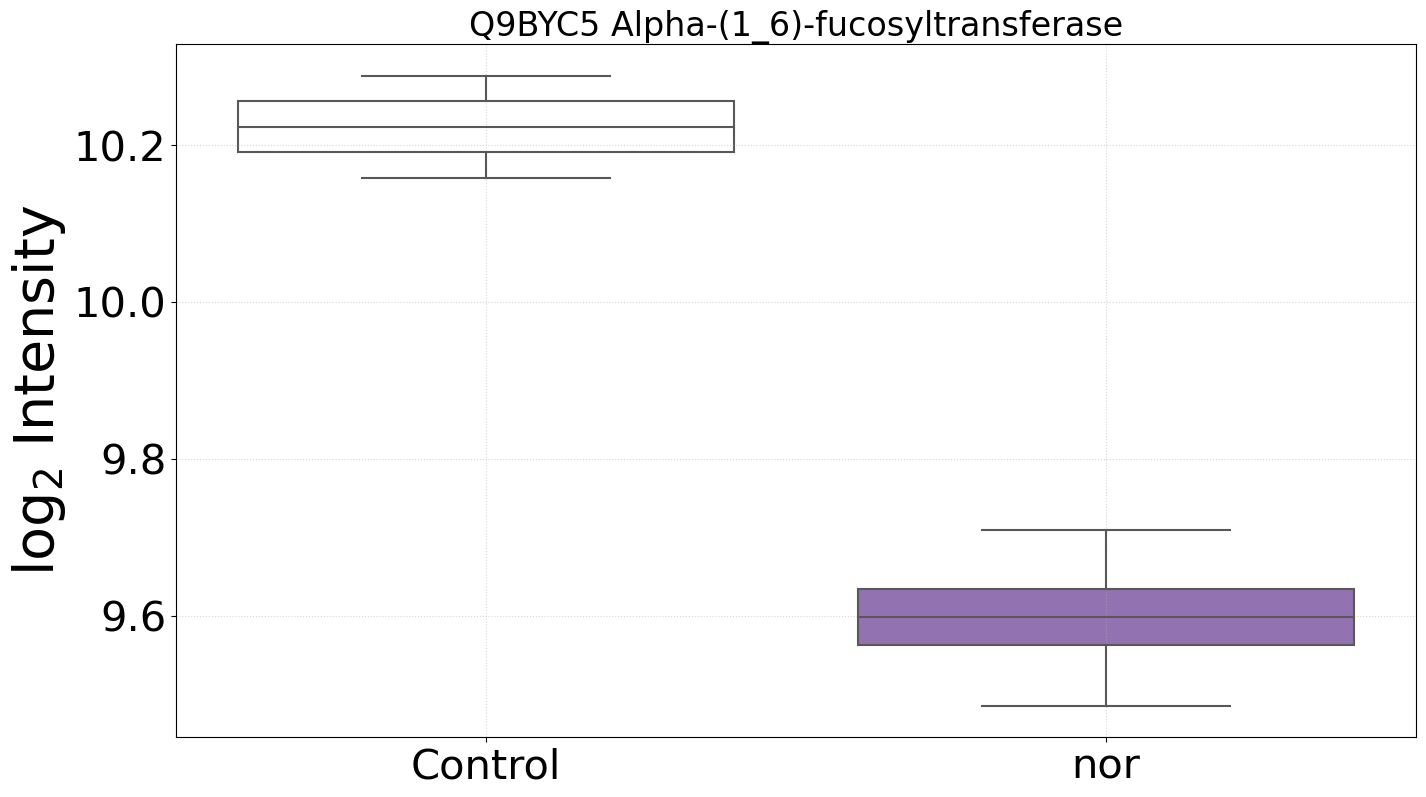

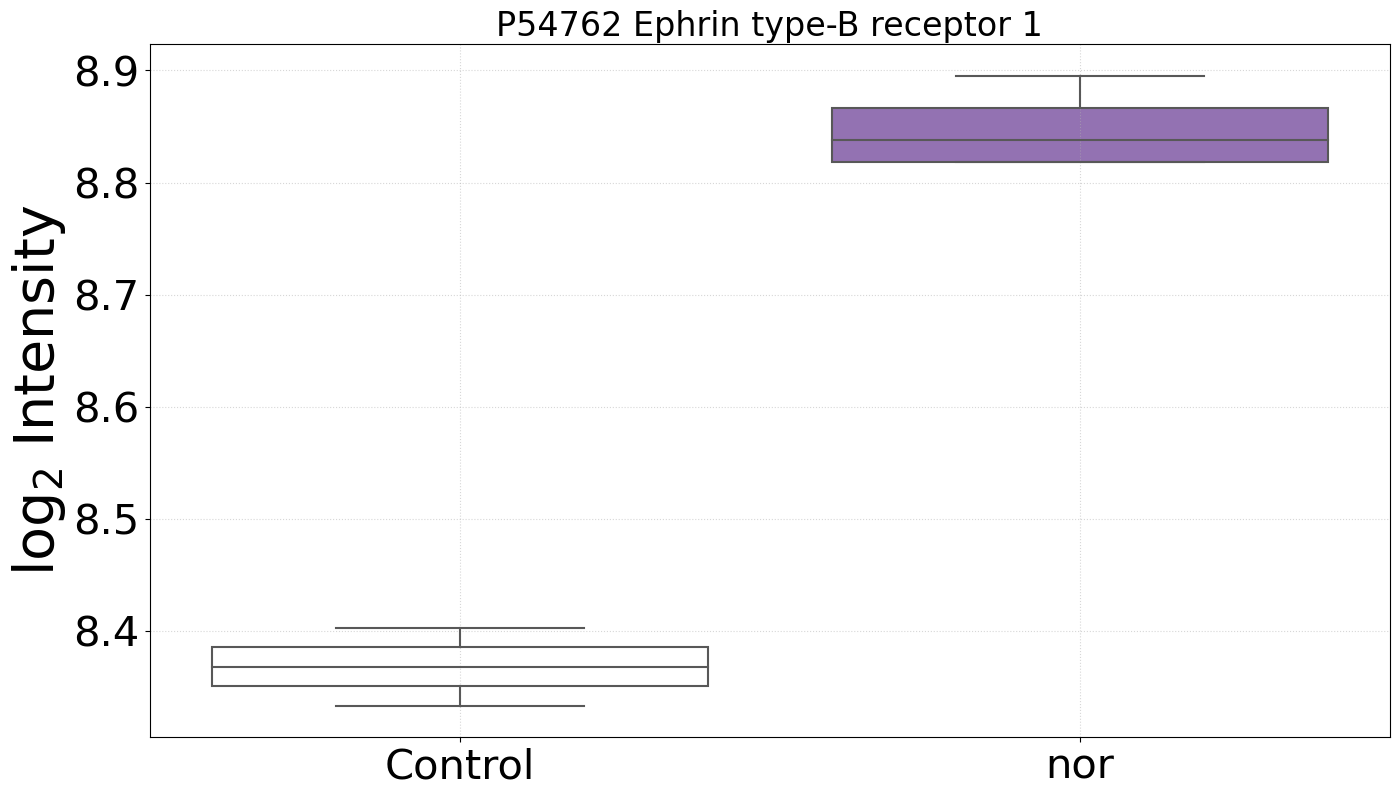

In [25]:
treatment_label = 'nor'
treatment_color = 'tab:purple'
control_samples = ['20220905_ARNAR_' + element for element in ['010', '011']]
treated_samples = ['20220905_ARNAR_' + element for element in ['020', '019', '014', '013']]
nor_response = comparison_function(detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

P before correction 0.0 1.0
5.981625932348072
max fold change 2.1204864947194686


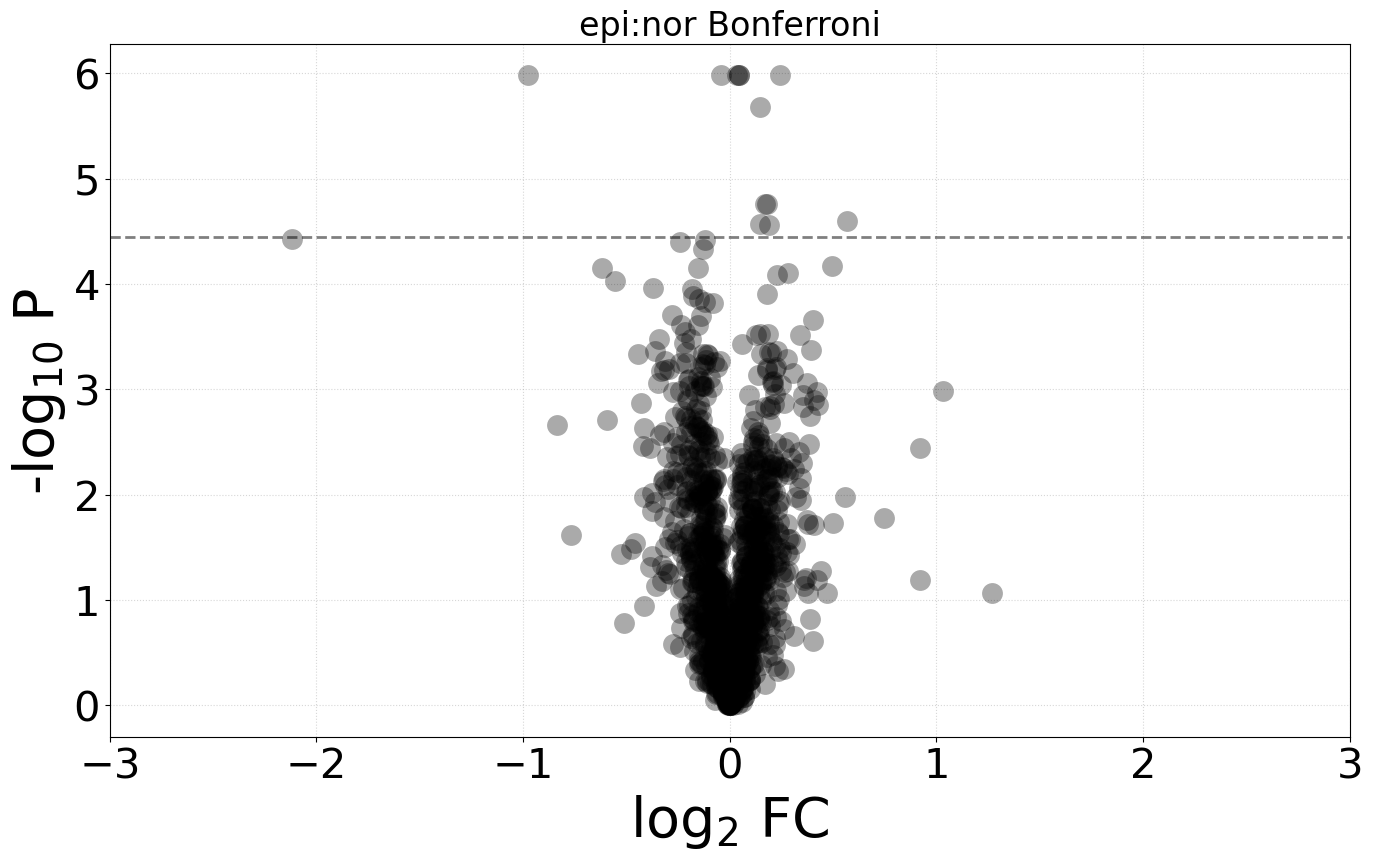

Benjamini-Hochberg correction
epsilon: 3.680595936684091
	 P17612 cAMP-dependent protein kinase catalytic subunit alpha [0.38, 1.53]
	 O43592 Exportin-T [-0.41, 1.61]
	 P54762 Ephrin type-B receptor 1 [0.35, 1.38]
	 P17661 Desmin [0.49, 2.28]
	 P01889 HLA class I histocompatibility antigen_ B alpha chain [1.03, 1.81]
	 Q9Y536;A0A075B759;F5H284;P0DN26 Peptidyl-prolyl cis-trans isomerase A-like 4A [0.41, 1.13]
	 O60749 Sorting nexin-2 [0.34, 1.50]
	 Q9Y5X1 Sorting nexin-9 [0.34, 1.96]
	 Q8IVE0 Putative ciliary rootlet coiled-coil protein-like 2 protein [-0.36, 1.27]
	 Q5EBL4 RILP-like protein 1 [0.92, 1.52]
	 Q86TV6 Tetratricopeptide repeat protein 7B [0.43, 1.74]
	 Q9UKX3;Q6PJF5 Myosin-13 [-0.55, 2.22]
	 Q8TC20 Cancer-associated gene 1 protein [0.41, 1.76]
	 A6NHC0 Calpain-8 [0.42, 1.81]
	 P0DPD8;P0DPD6 EEF1AKMT4-ECE2 readthrough transcript protein [-0.44, 1.91]
	 Q5TF21 Protein SOGA3 [0.35, 1.44]
	 P04350 Tubulin beta-4A chain [-0.59, 1.66]
	 Q9UKY7 Protein CDV3 homolog [0.56, 1.29]
	 

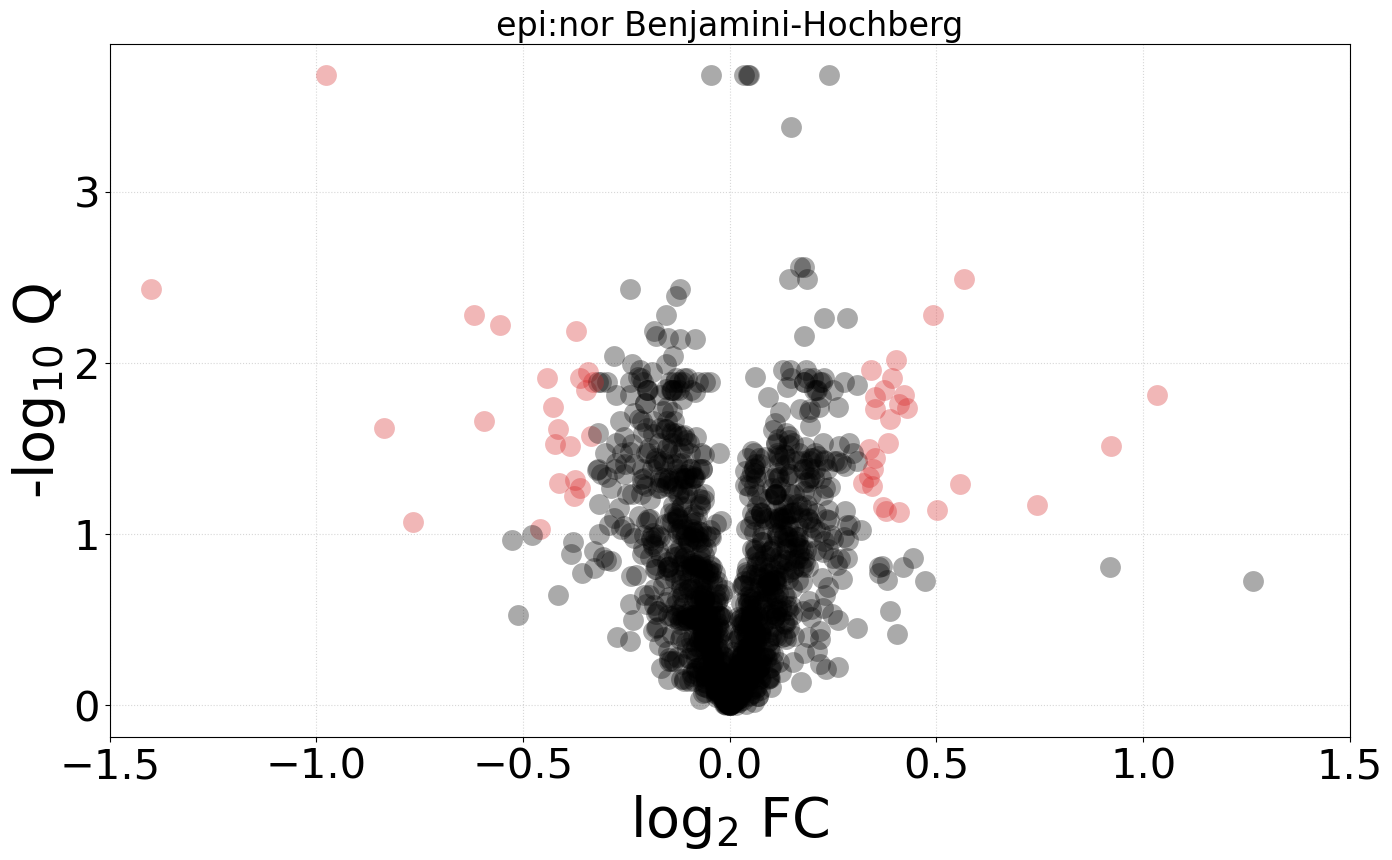

50 proteins respond to treatment


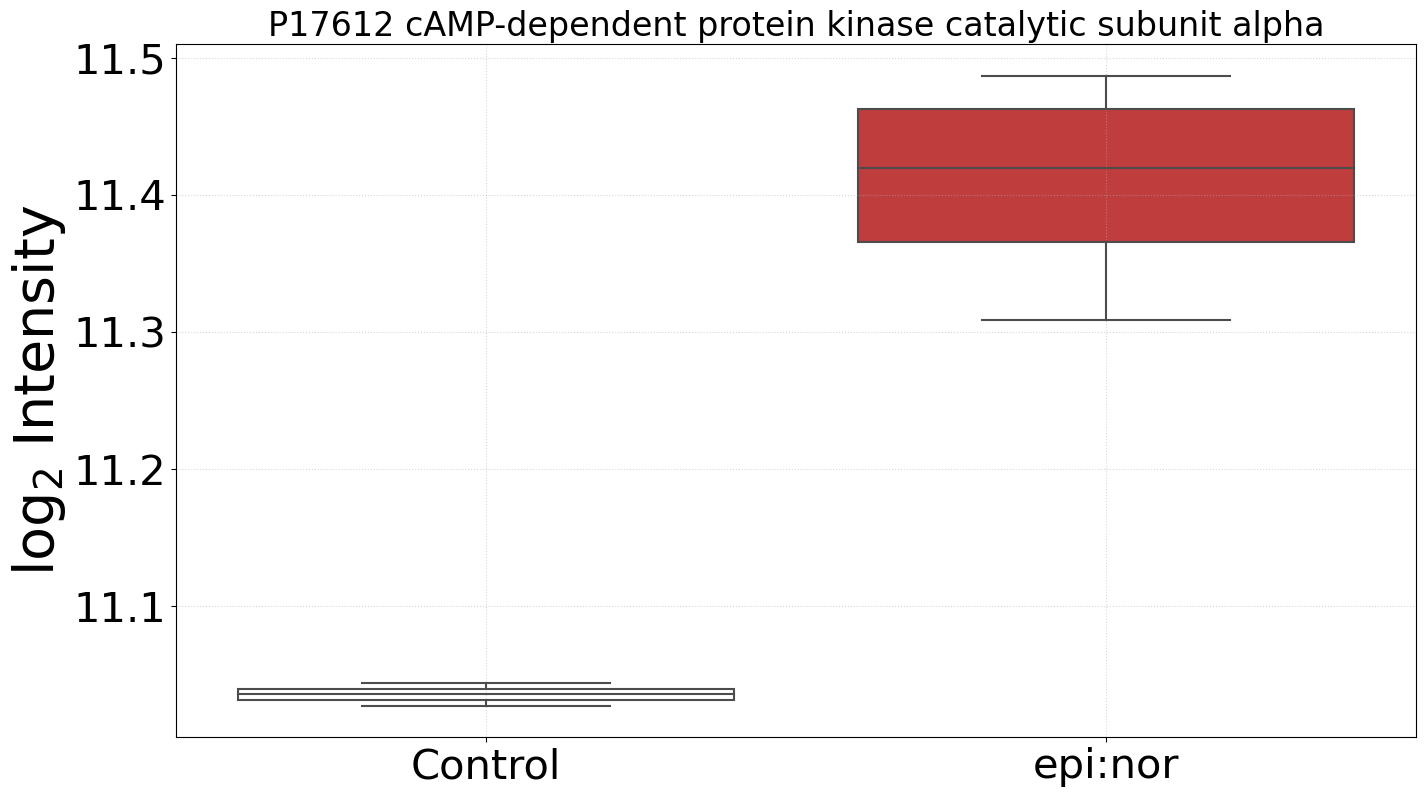

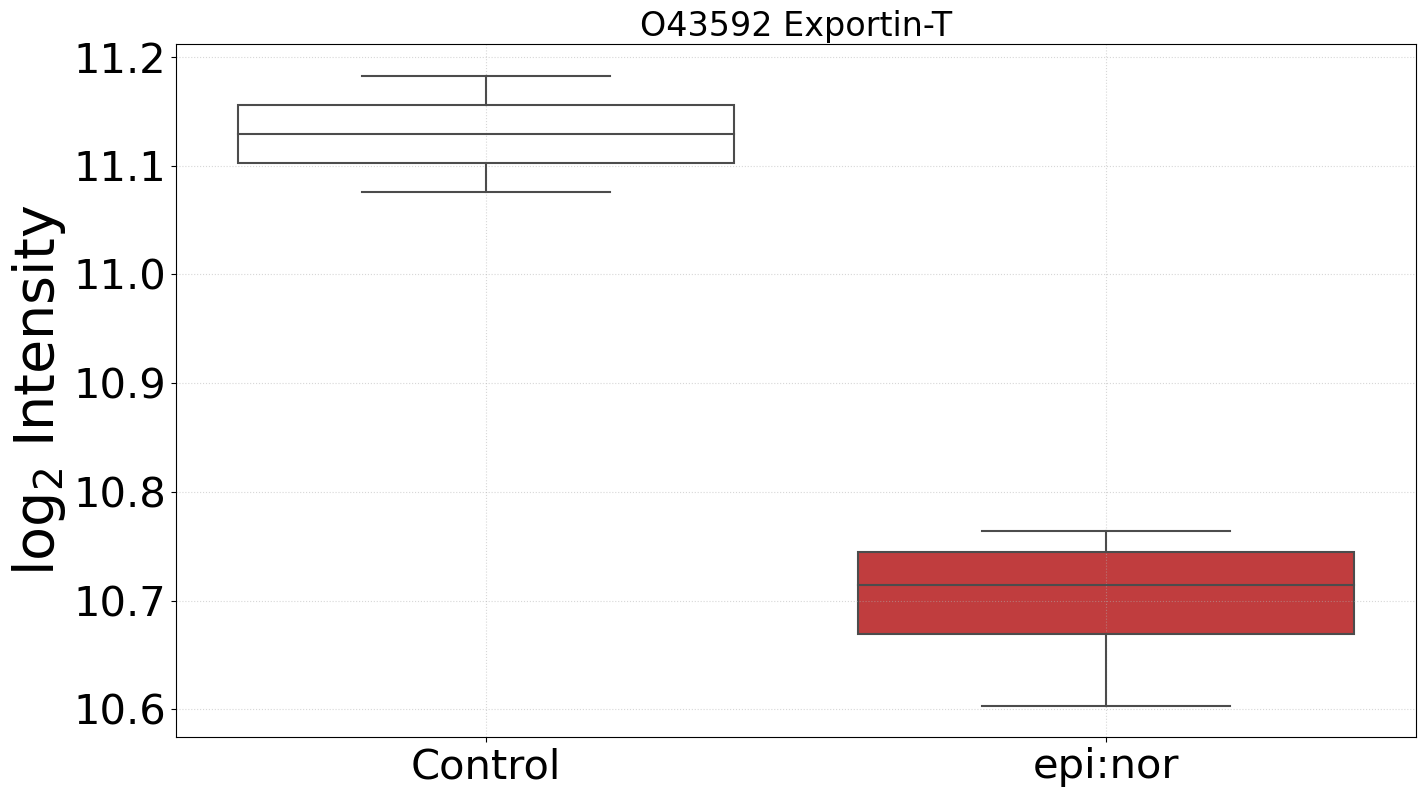

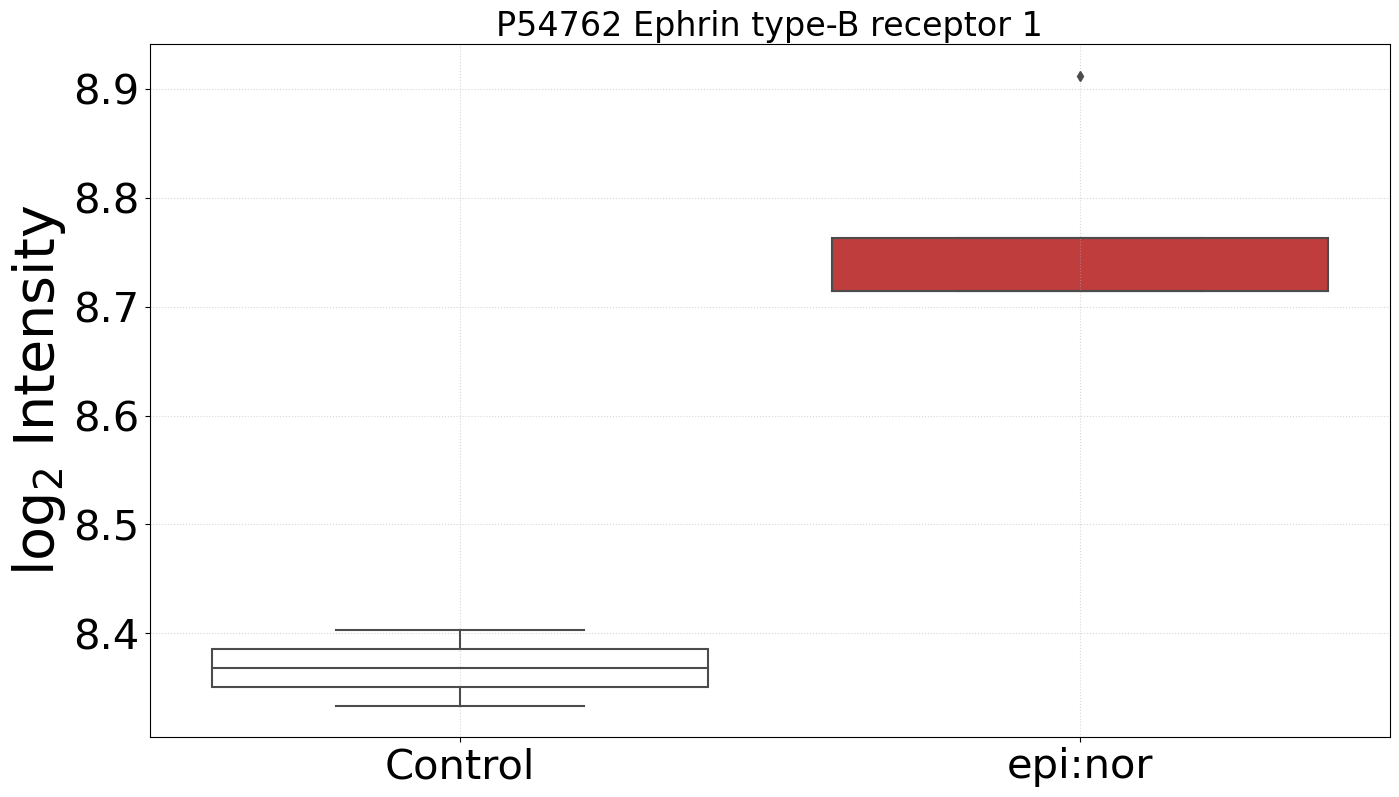

In [26]:
treatment_label = 'epi:nor'
treatment_color = 'tab:red'
control_samples = ['20220905_ARNAR_' + element for element in ['010', '011']]
treated_samples = ['20220905_ARNAR_' + element for element in ['025', '024', '026', '027']]
epinor_response = comparison_function(detected_biomarkers, qndf, treatment_label, treatment_color, control_samples, treated_samples)

### Venn diagram of treatmens

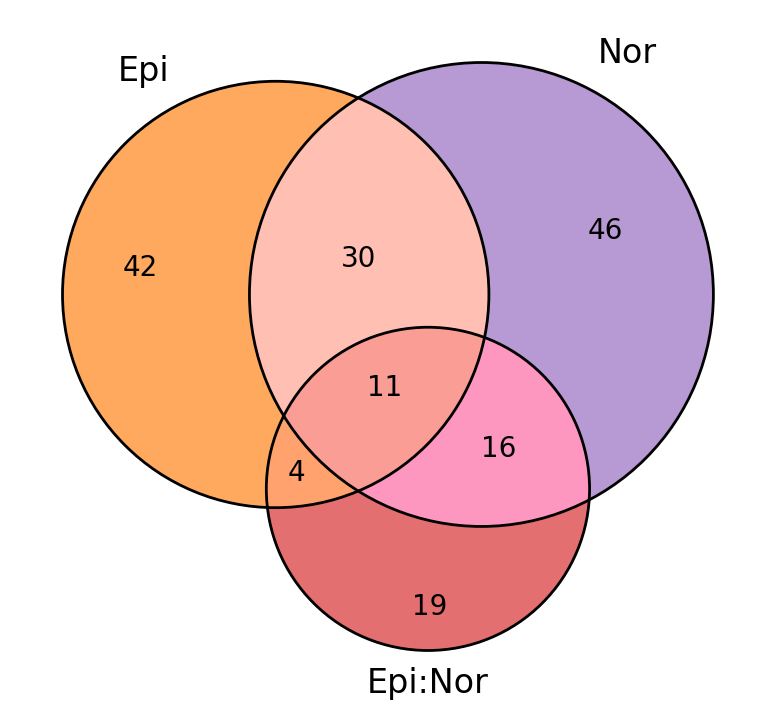

In [27]:
matplotlib_venn.venn3(
    [set(epi_response), set(nor_response), set(epinor_response)], 
    set_labels=('Epi', 'Nor', 'Epi:Nor'),
    set_colors=('tab:orange', 'tab:purple', 'tab:red'),
    alpha=2/3
)
matplotlib_venn.venn3_circles(
    [set(epi_response), set(nor_response), set(epinor_response)],
    linewidth=2
)
matplotlib.pyplot.show()

# LATE samples

### define metadata

In [28]:
metadata = {}

metadata['24h control'] = ['20220905_ARNAR_022', '20220905_ARNAR_023', '20220905_ARNAR_037', '20220905_ARNAR_038', '20220905_ARNAR_067', '20220905_ARNAR_068']

metadata['24h epi'] = ['20220905_ARNAR_031', '20220905_ARNAR_040']

metadata['24h nor'] = ['20220905_ARNAR_028', '20220905_ARNAR_053', '20220905_ARNAR_054', '20220905_ARNAR_062']

metadata['24h epinor'] = ['20220905_ARNAR_006', '20220905_ARNAR_007', '20220905_ARNAR_033', '20220905_ARNAR_034', '20220905_ARNAR_055']

metadata['24h TNFa'] = ['20220905_ARNAR_015', '20220905_ARNAR_016', '20220905_ARNAR_017', '20220905_ARNAR_018', '20220905_ARNAR_042', '20220905_ARNAR_043']

all_sample_names = [element for sublist in list(metadata.values()) for element in sublist]
print(len(all_sample_names))

23


### manipulate data

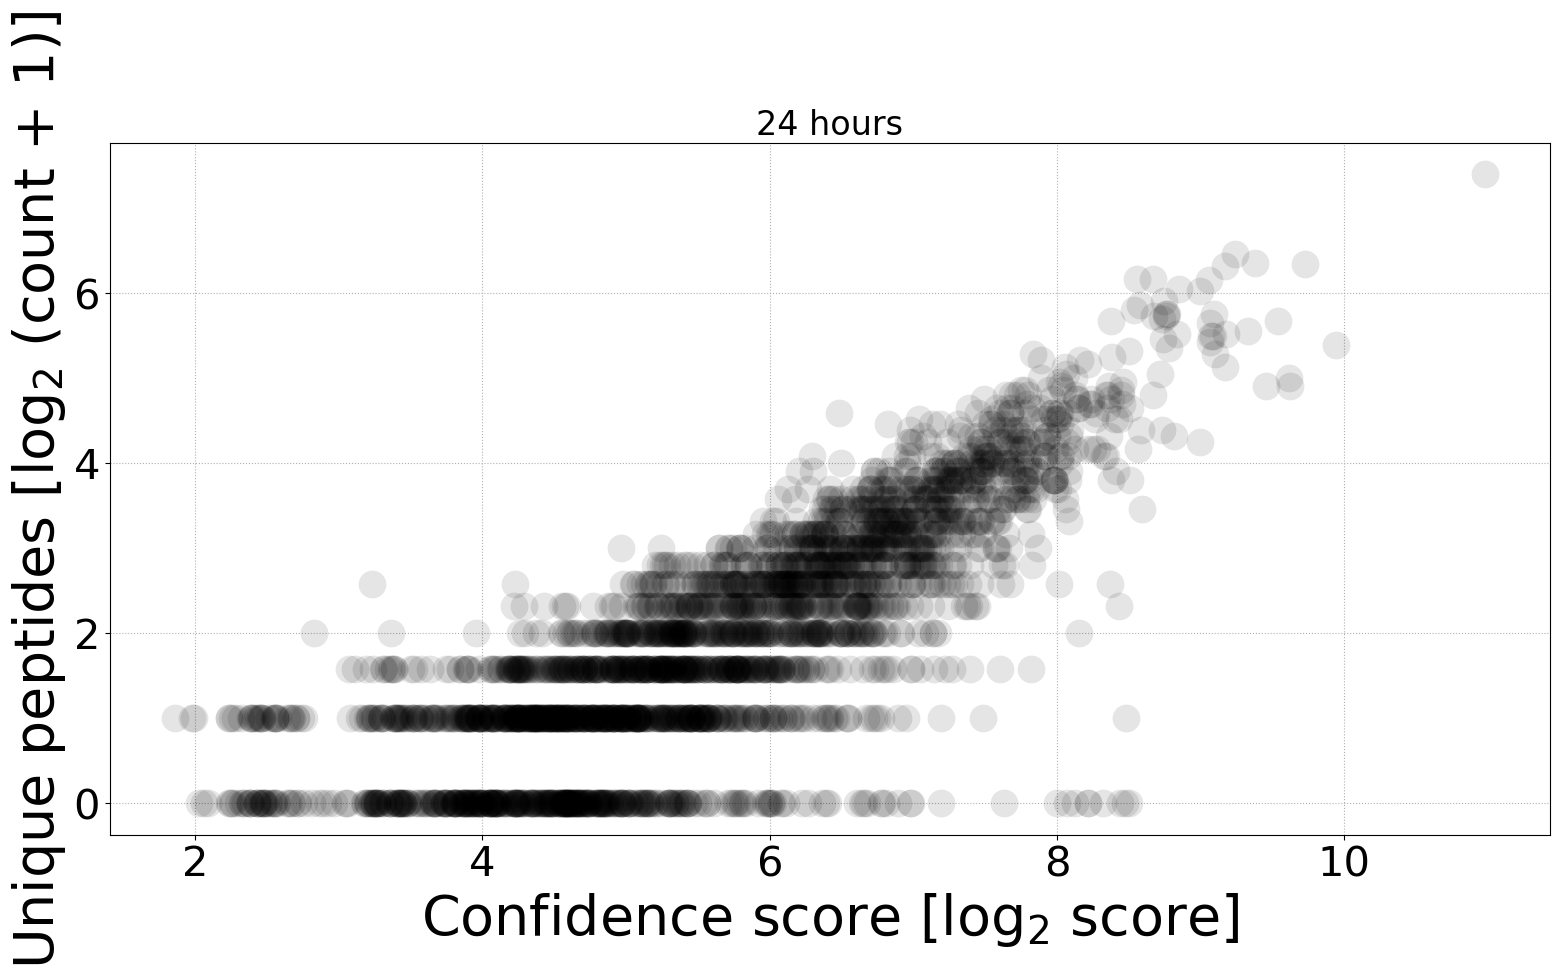

In [29]:
x = numpy.log2(df24['Confidence score'])
y = numpy.log2(df24['Unique peptides']+1)
               
matplotlib.pyplot.plot(x, y, 'o', color='black', alpha=1/10, markeredgecolor='None', ms=20)

matplotlib.pyplot.xlabel('Confidence score [log$_2$ score]')
matplotlib.pyplot.ylabel('Unique peptides [log$_2$ (count + 1)]')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.title('24 hours')
matplotlib.pyplot.tight_layout()

Arbitrary thresholds for minimal identifications:
- X-axis: a score of >= 50.
- Y-axis: at least three unique peptides.

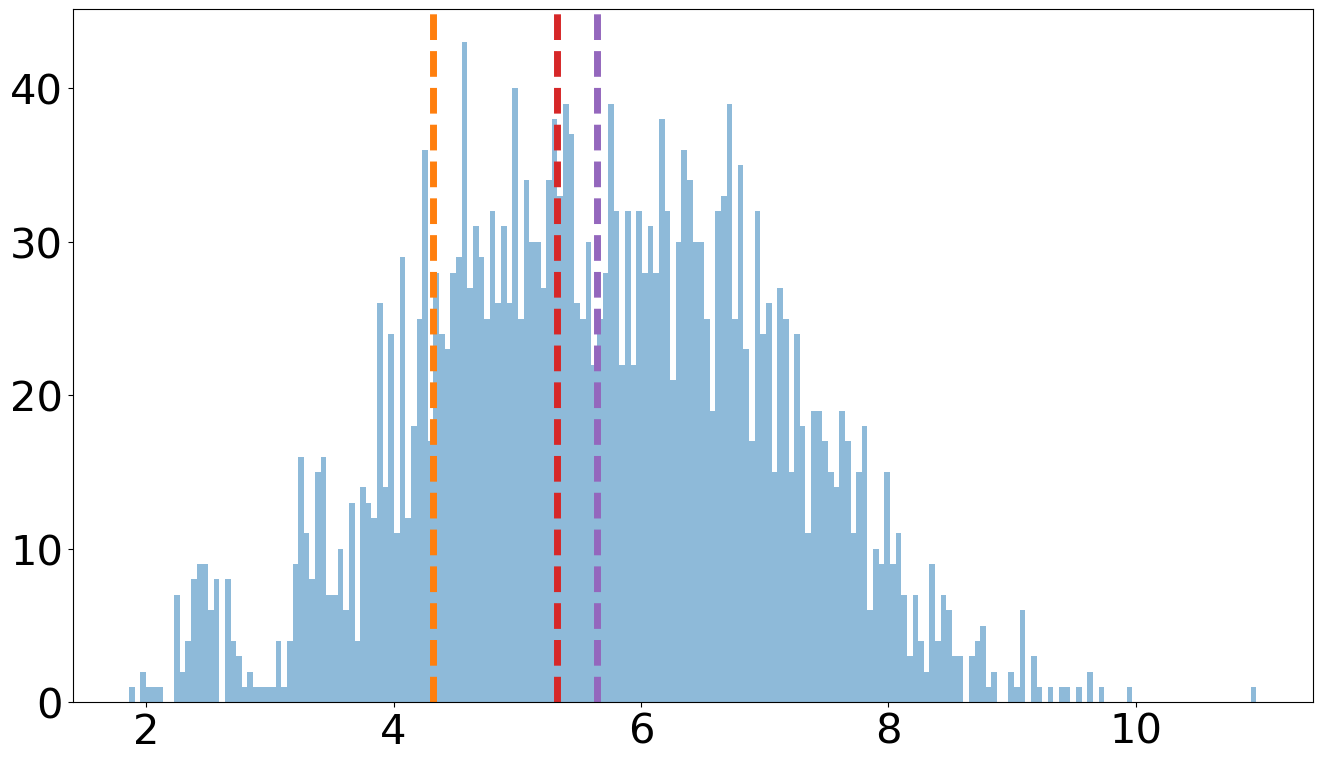

In [30]:
matplotlib.pyplot.hist(numpy.log2(df24['Confidence score']), bins=200, alpha=1/2, color='tab:blue')
matplotlib.pyplot.axvline(x=numpy.log2(20), lw=5, ls='--', color='tab:orange')
matplotlib.pyplot.axvline(x=numpy.log2(40), lw=5, ls='--', color='tab:red')
matplotlib.pyplot.axvline(x=numpy.log2(50), lw=5, ls='--', color='tab:purple')
matplotlib.pyplot.show()

In [31]:
new24 = df24[(df24['Unique peptides'] >= 3) & (df24['Confidence score'] >= 50)]
print(new24.shape)

working_labels = [label for label in new24.columns if label in all_sample_names]

new24 = numpy.log2(new24.loc[:, working_labels] + 1)
print(new24.shape)
new24

(1146, 83)
(1146, 23)


20220905_ARNAR_022  20220905_ARNAR_023  \
Accession                                                                    
P05362                                       12.136222           12.096396   
P10321                                       11.904654           11.900532   
Q15386                                       12.568446           12.518951   
Q06323                                       11.894029           11.874543   
Q92538                                       14.821087           14.874703   
...                                                ...                 ...   
Q86SQ0;O43511                                13.182738           13.287457   
Q9NTJ4                                       12.825811           12.821668   
P60981                                       12.949406           12.950136   
Q9HCF6                                       12.937486           12.919516   
O94851;A6NMT0;O43151;P50897;Q8N865           13.992718           14.006149   

                                    20220905_ARNAR_037  20220905_ARNAR_038  \
Accession                                                                    
P05362                                       12.003133           12.087096   
P10321                                       11.841072           11.837779   
Q15386                                       12.666620           12.368442   
Q06323                                       11.872941           11.968498   
Q92538                                       14.790360           14.920397   
...                                                ...                 ...   
Q86SQ0;O43511                                13.266780           13.318024   
Q9NTJ4                                       12.951944           13.074719   
P60981                                       12.855742           12.883994   
Q9HCF6                                       12.849802           12.934045   
O94851;A6NMT0;O43151;P50897;Q8N865           13.955995           14.146705   

                                    20220905_ARNAR_067  20220905_ARNAR_068  \
Accession                                                                    
P05362                                       12.063444           11.987530   
P10321                                       11.990171           11.981418   
Q15386                                       12.505658           12.417328   
Q06323                                       12.023337           12.019146   
Q92538                                       15.002750           15.062303   
...                                                ...                 ...   
Q86SQ0;O43511                                13.307603           13.324157   
Q9NTJ4                                       13.008411           12.993811   
P60981                                       13.061916           12.963713   
Q9HCF6                                       13.055863           12.955092   
O94851;A6NMT0;O43151;P50897;Q8N865           14.152282           14.107456   

                                    20220905_ARNAR_015  20220905_ARNAR_016  \
Accession                                                                    
P05362                                       15.026937           15.053167   
P10321                                       12.686021           12.677490   
Q15386                                       11.596525           11.570211   
Q06323                                       12.205800           12.206725   
Q92538                                       14.817534           14.847160   
...                                                ...                 ...   
Q86SQ0;O43511                                13.122355           13.074455   
Q9NTJ4                                       12.781201           12.802997   
P60981                                       12.877931           12.710013   
Q9HCF6                                       12.668605           12.674253   
O94851;A6NMT0;O43151;P50897;Q8N865           13.974448 

### biomarker analysis

In [32]:
detected_biomarkers = {}
for biomarker in biomarkers.keys():
    uniprot_id = biomarkers[biomarker]
    print('working with biomarker {}, uniprot {}'.format(biomarker, uniprot_id))
    for element in df24.index:
        if uniprot_id in element:
            print('\t{}, peptide count {}, score {}'.format(element, df24.loc[element, 'Unique peptides'], df24.loc[element, 'Confidence score']))
            detected_biomarkers[element] = biomarker

detected_biomarkers.keys()

working with biomarker endothelin, uniprot P05305
working with biomarker PAI-1, uniprot P05121
	P05121, peptide count 19, score 160.2717
working with biomarker uPA, uniprot P00749
working with biomarker VCAM-1, uniprot P19320
working with biomarker L-selectin, uniprot P14151
working with biomarker Ang2, uniprot O15123
working with biomarker VEGFr1, uniprot P17948
working with biomarker ICAM-2, uniprot P13598
	P13598, peptide count 3, score 61.8311
working with biomarker tie2, uniprot Q02763
working with biomarker IL-6, uniprot P05231
working with biomarker E-selectin, uniprot P16581
working with biomarker ICAM-1, uniprot P05362
	P05362, peptide count 14, score 73.6527
working with biomarker P-selectin, uniprot P16109
working with biomarker Ang1, uniprot Q15389
working with biomarker vWF, uniprot P04275
working with biomarker PDGF, uniprot P01127
working with biomarker endocan, uniprot Q9NQ30
working with biomarker TNFa, uniprot P01375
working with biomarker VEGFa, uniprot P15692


dict_keys(['P05121', 'P13598', 'P05362'])

(1040, 83)
(1040, 23)
P05121 24h control
P05121 24h epi
P05121 24h nor
P05121 24h epinor
P05121 24h TNFa
PAI-1 [15.77791873779686, 16.49764157230824, 16.185735079823054, 16.07947562041897, 15.851509838137147]
P13598 24h control
P13598 24h epi
P13598 24h nor
P13598 24h epinor
P13598 24h TNFa
ICAM-2 [11.131536385753769, 11.444847941235231, 11.193534415906356, 11.177672704391076, 11.087425869879528]
P05362 24h control
P05362 24h epi
P05362 24h nor
P05362 24h epinor
P05362 24h TNFa
ICAM-1 [12.036392683025387, 12.134317382407897, 12.02711472301743, 12.051852877468017, 15.051720893630321]
{'PAI-1': [0.0, 0.71972283451138, 0.40781634202619443, 0.301556882622112, 0.0735911003402876], 'ICAM-2': [0.0, 0.3133115554814623, 0.06199803015258709, 0.04613631863730738, -0.044110515874240974], 'ICAM-1': [0.0, 0.09792469938251003, -0.009277960007956665, 0.015460194442630026, 3.0153282106049346]}


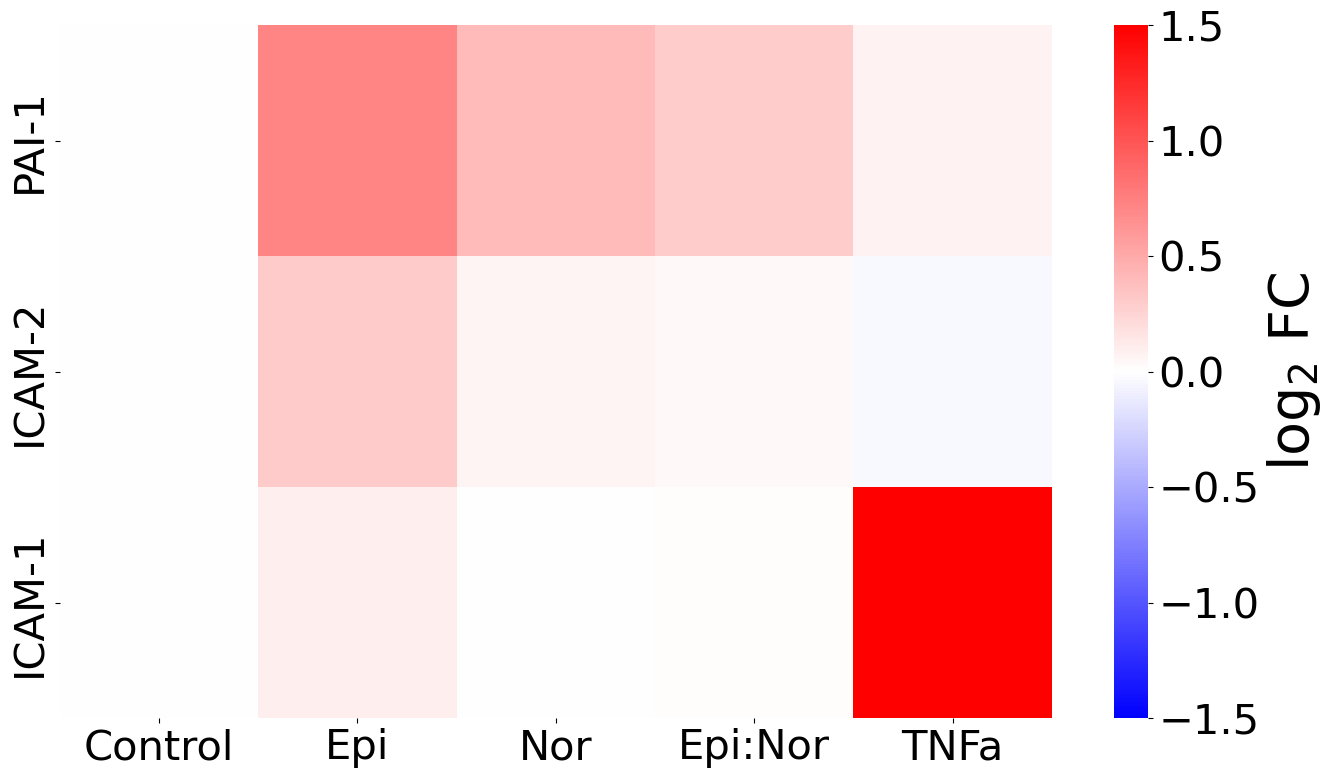

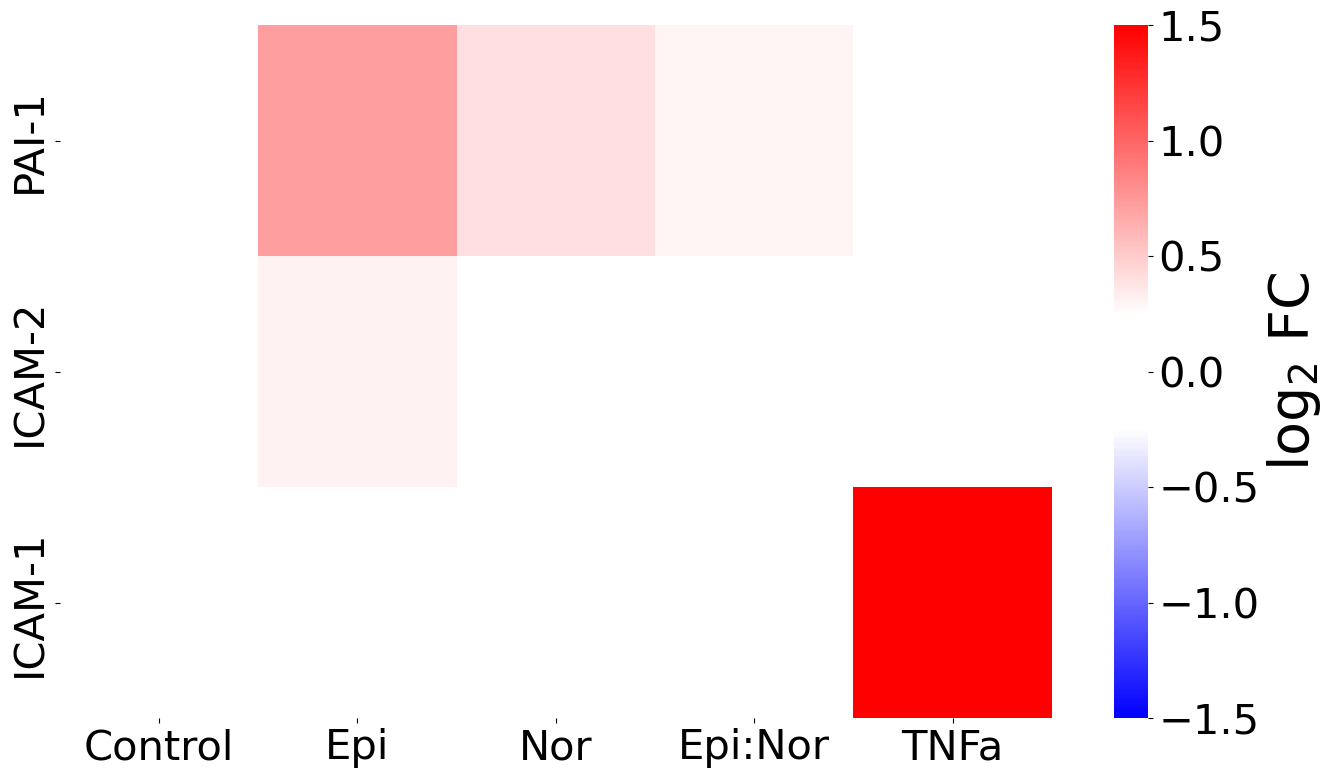

In [33]:
# P13598, peptide count 3, score 61.8311
biomarkers_df = df24[(df24['Unique peptides'] >= 3) & (df24['Confidence score'] >= 61)]
print(biomarkers_df.shape)
biomarkers_df = numpy.log2(biomarkers_df.loc[:, working_labels] + 1)
print(biomarkers_df.shape)

### normalization
# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(biomarkers_df.values, axis=0), index=biomarkers_df.index, columns=biomarkers_df.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qnbiodf = biomarkers_df.rank(method="min").stack().astype(int).map(df_mean).unstack()

# gererate data for heatmap
heatmap_data = {}
for marker in detected_biomarkers.keys():
    heatmap_data[detected_biomarkers[marker]] = []
    for treatment in metadata.keys():
        print(marker, treatment)
        log2_intensity = numpy.median(qnbiodf.loc[marker, metadata[treatment]].values)
        heatmap_data[detected_biomarkers[marker]].append(log2_intensity)
    print(detected_biomarkers[marker], heatmap_data[detected_biomarkers[marker]])

for biomarker in heatmap_data:
    reference = heatmap_data[biomarker][0]
    for i in range(len(heatmap_data[biomarker])):
        heatmap_data[biomarker][i] = heatmap_data[biomarker][i] - reference
print(heatmap_data)
heatmap_df = pandas.DataFrame.from_dict(heatmap_data).transpose()
heatmap_df.columns = ['Control', 'Epi', 'Nor', 'Epi:Nor', 'TNFa']

colors = [(0, "blue"), (0.5-(1/12), "white"), (0.5+(1/12), "white"), (1, "red")]
bwwr = matplotlib.colors.LinearSegmentedColormap.from_list("bwwr", colors)

seaborn.heatmap(data=heatmap_df, cmap='bwr', vmin=-1.5, vmax=1.5, cbar_kws={'label':'log$_2$ FC'})
matplotlib.pyplot.show()

seaborn.heatmap(data=heatmap_df, cmap=bwwr, vmin=-1.5, vmax=1.5, cbar_kws={'label':'log$_2$ FC'})
matplotlib.pyplot.show()

### visualize data

210
20220905_ARNAR_006
20220905_ARNAR_007
20.44118100653228


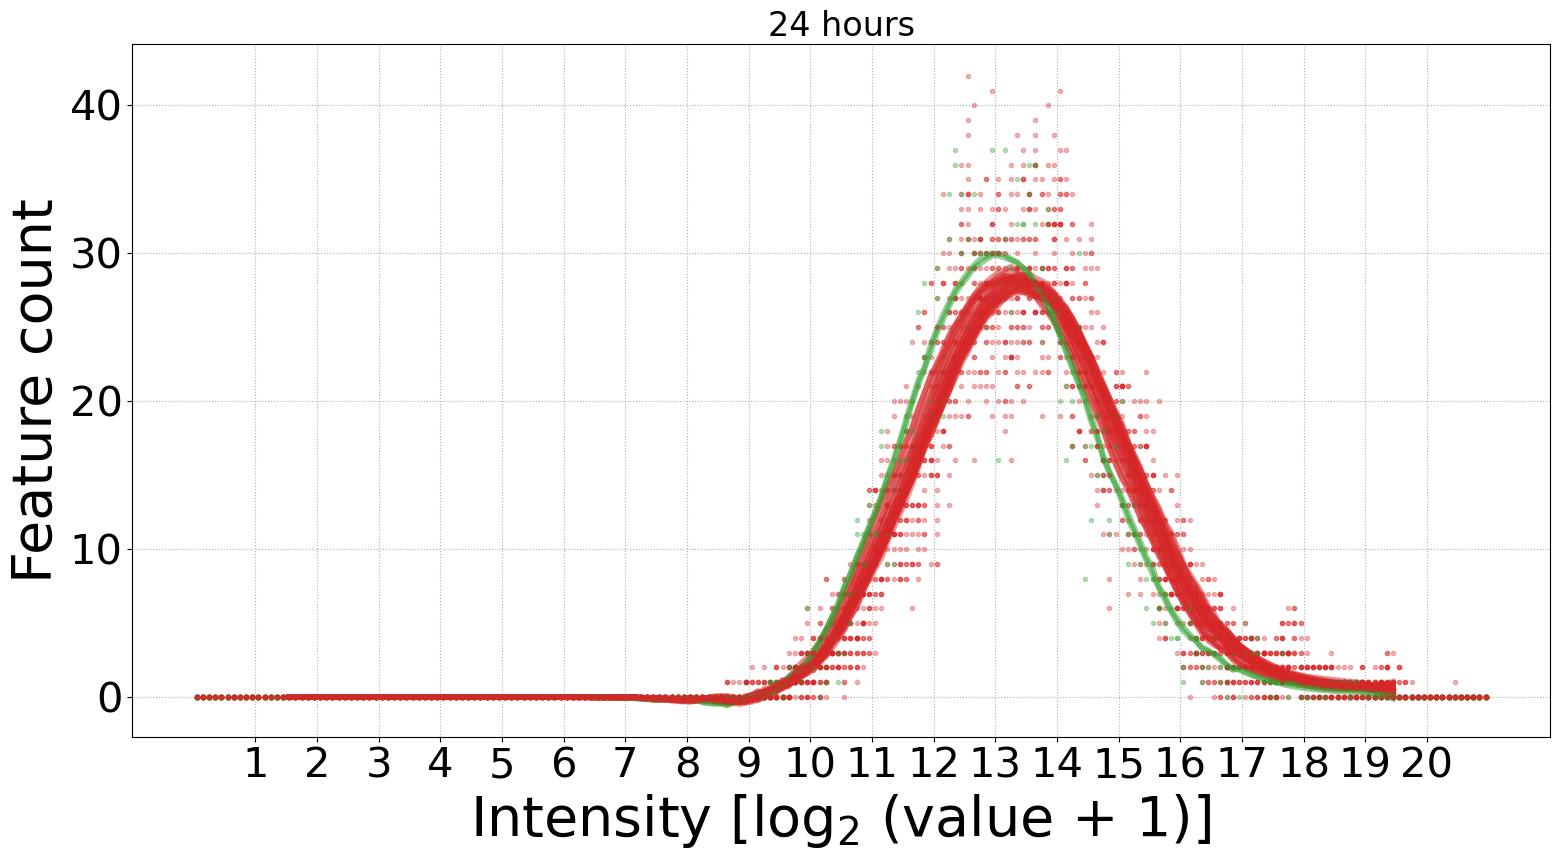

In [34]:
found_max = 21
number_of_bins = found_max * 10
margin = 15
print(number_of_bins)

absolute_max = 0
plotting_x = []; plotting_y = []
most_likely_early = []

for sample in new24.columns:
        
    intensities = new24.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(intensities, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # storing info to quantify bias
    most_likely_intensity = x[numpy.argmax(yhat)]
    most_likely_early.append(most_likely_intensity)
    
    
    # plotting
    the_color = 'tab:red'
    if '006' in sample or '007' in sample:
        the_color = 'tab:green'
        print(sample)
    matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color=the_color)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color=the_color)
    
    # check
    if max(intensities) > absolute_max:
        absolute_max = max(intensities)

# check print
print(absolute_max)

matplotlib.pyplot.xticks(range(1, 21))
matplotlib.pyplot.xlabel('Intensity [log$_2$ (value + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.title('24 hours')
matplotlib.pyplot.tight_layout()

### normalization

In [35]:
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(new24.values, axis=0), index=new24.index, columns=new24.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = new24.rank(method="min").stack().astype(int).map(df_mean).unstack()

### distributions after normalization

210
19.408569280865084


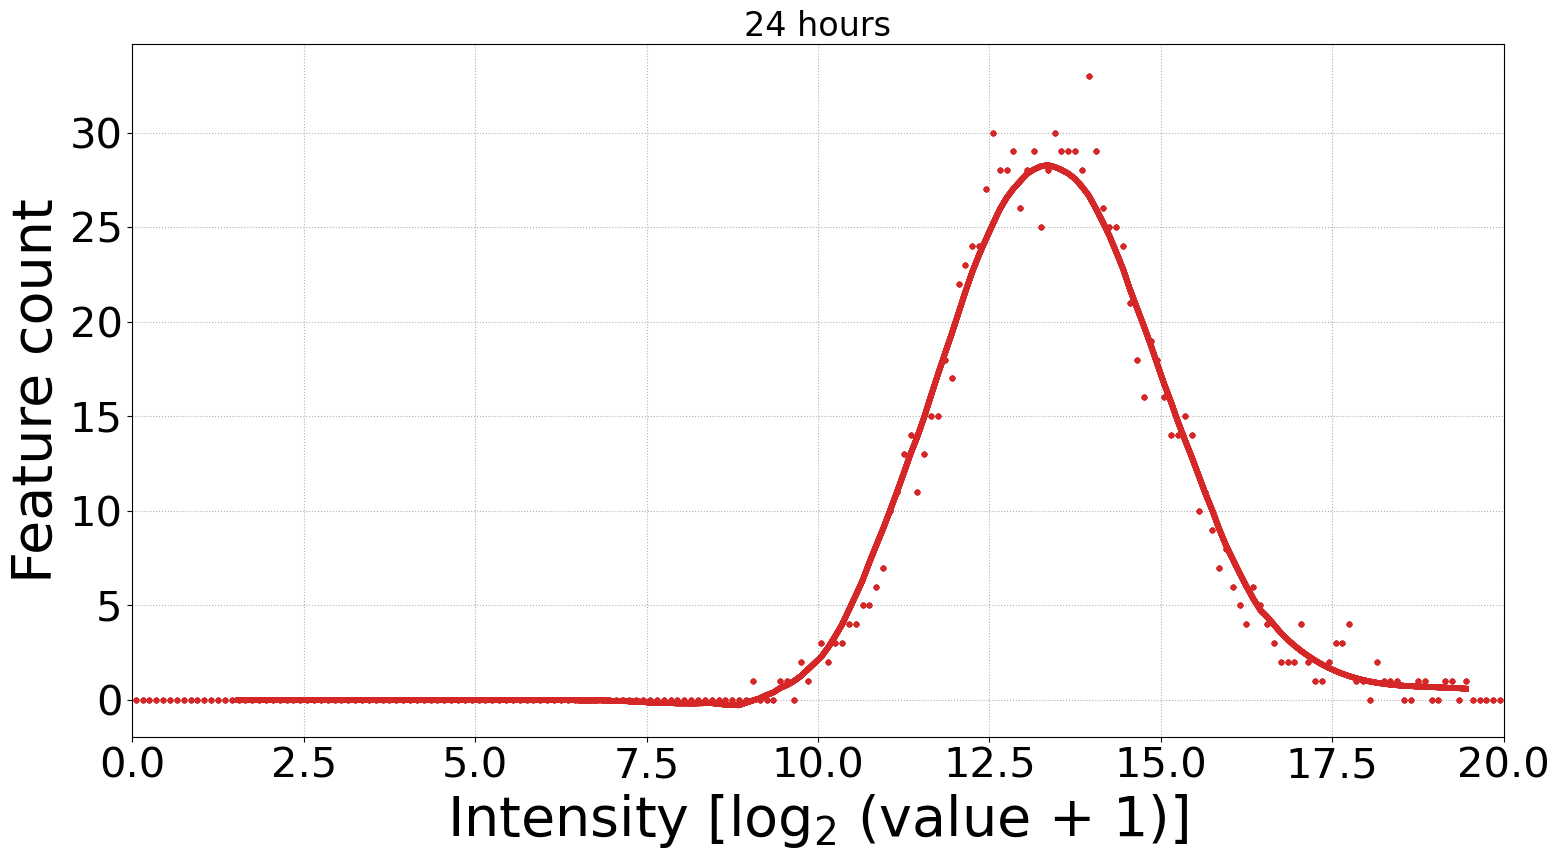

In [36]:
found_max = 21
number_of_bins = found_max * 10
margin = 15
print(number_of_bins)

absolute_max = 0
plotting_x = []; plotting_y = []
most_likely_early = []

for sample in qndf.columns:
        
    intensities = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(intensities, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # storing info to quantify bias
    most_likely_intensity = x[numpy.argmax(yhat)]
    most_likely_early.append(most_likely_intensity)
    
    
    # plotting
    the_color = 'tab:red'
    matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color=the_color)
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color=the_color)
    
    # check
    if max(intensities) > absolute_max:
        absolute_max = max(intensities)

# check print
print(absolute_max)

matplotlib.pyplot.xlim(0,20)
matplotlib.pyplot.xlabel('Intensity [log$_2$ (value + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.title('24 hours')
matplotlib.pyplot.tight_layout()

### PCA

[0.32556867 0.16003256]


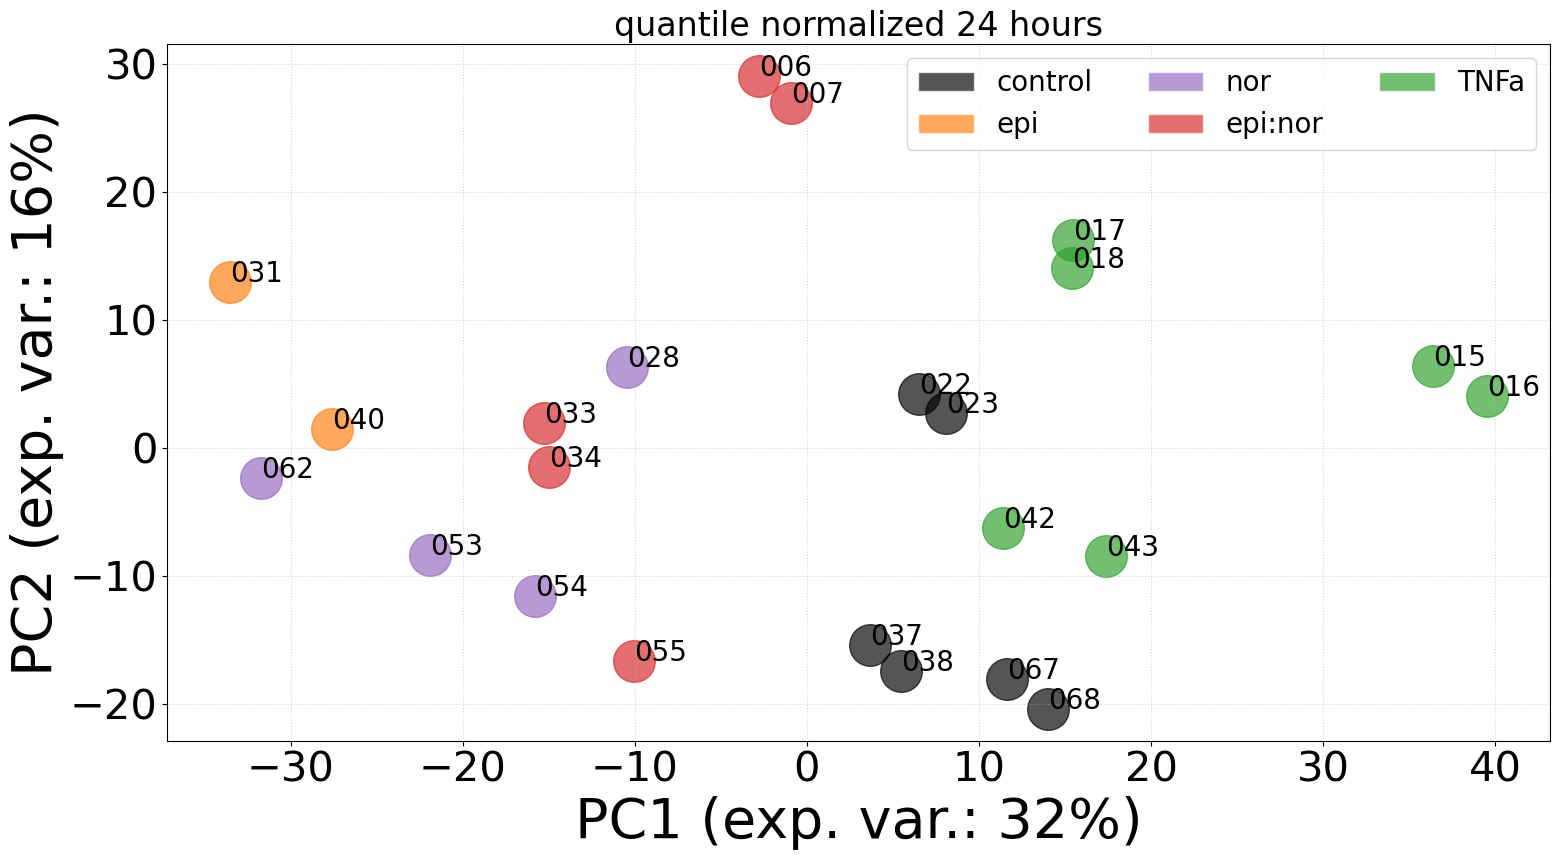

In [37]:
# quantile normalized all
transpose = qndf.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
    the_label = qndf.columns[i].split('_')[-1]
        
    if qndf.columns[i] in metadata['24h control']:
        the_color = 'black'
    elif qndf.columns[i] in metadata['24h epi']:
        the_color = 'tab:orange'
    elif qndf.columns[i] in metadata['24h nor']:
        the_color = 'tab:purple'
    elif qndf.columns[i] in metadata['24h epinor']:
        the_color = 'tab:red'
    elif qndf.columns[i] in metadata['24h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
    
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label)
    
legend_elements = [ 
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('quantile normalized 24 hours')
matplotlib.pyplot.tight_layout()

[0.51913175 0.19178318]


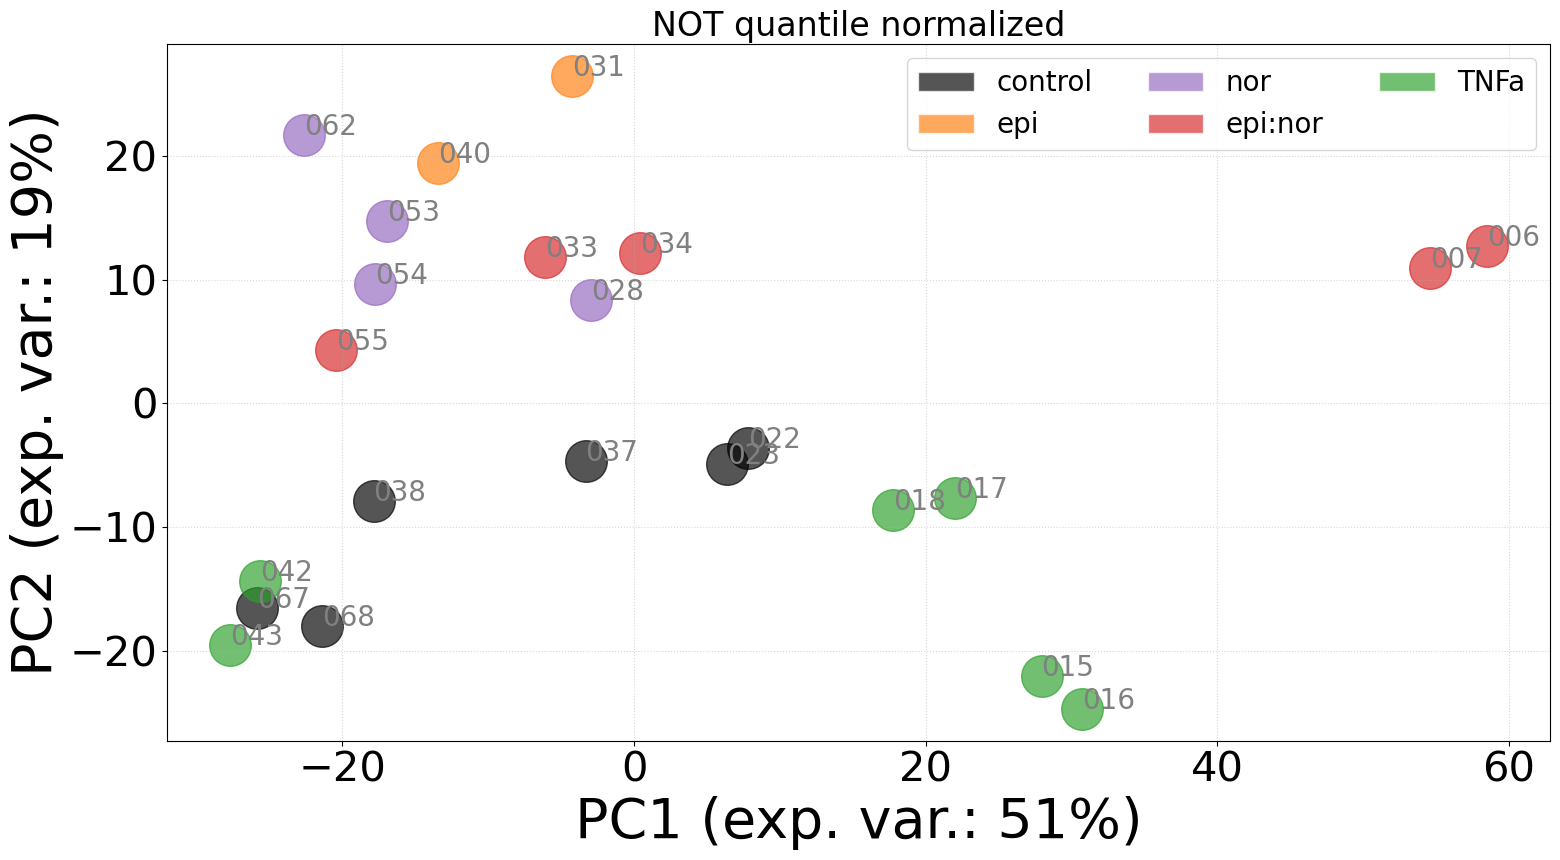

In [38]:
# non-quantile normalized all
transpose = new24.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
        
    if qndf.columns[i] in metadata['24h control']:
        the_color = 'black'
    elif qndf.columns[i] in metadata['24h epi']:
        the_color = 'tab:orange'
    elif qndf.columns[i] in metadata['24h nor']:
        the_color = 'tab:purple'
    elif qndf.columns[i] in metadata['24h epinor']:
        the_color = 'tab:red'
    elif qndf.columns[i] in metadata['24h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
        
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    
    the_label = new24.columns[i].split('_')[-1]
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label, color='gray')

    
legend_elements = [
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=3)

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.title('NOT quantile normalized')

matplotlib.pyplot.tight_layout()

7
['20220905_ARNAR_022', '20220905_ARNAR_023', '20220905_ARNAR_042', '20220905_ARNAR_043', '20220905_ARNAR_006', '20220905_ARNAR_007', '20220905_ARNAR_028']
(1146, 16)
[0.39075559 0.1768133 ]


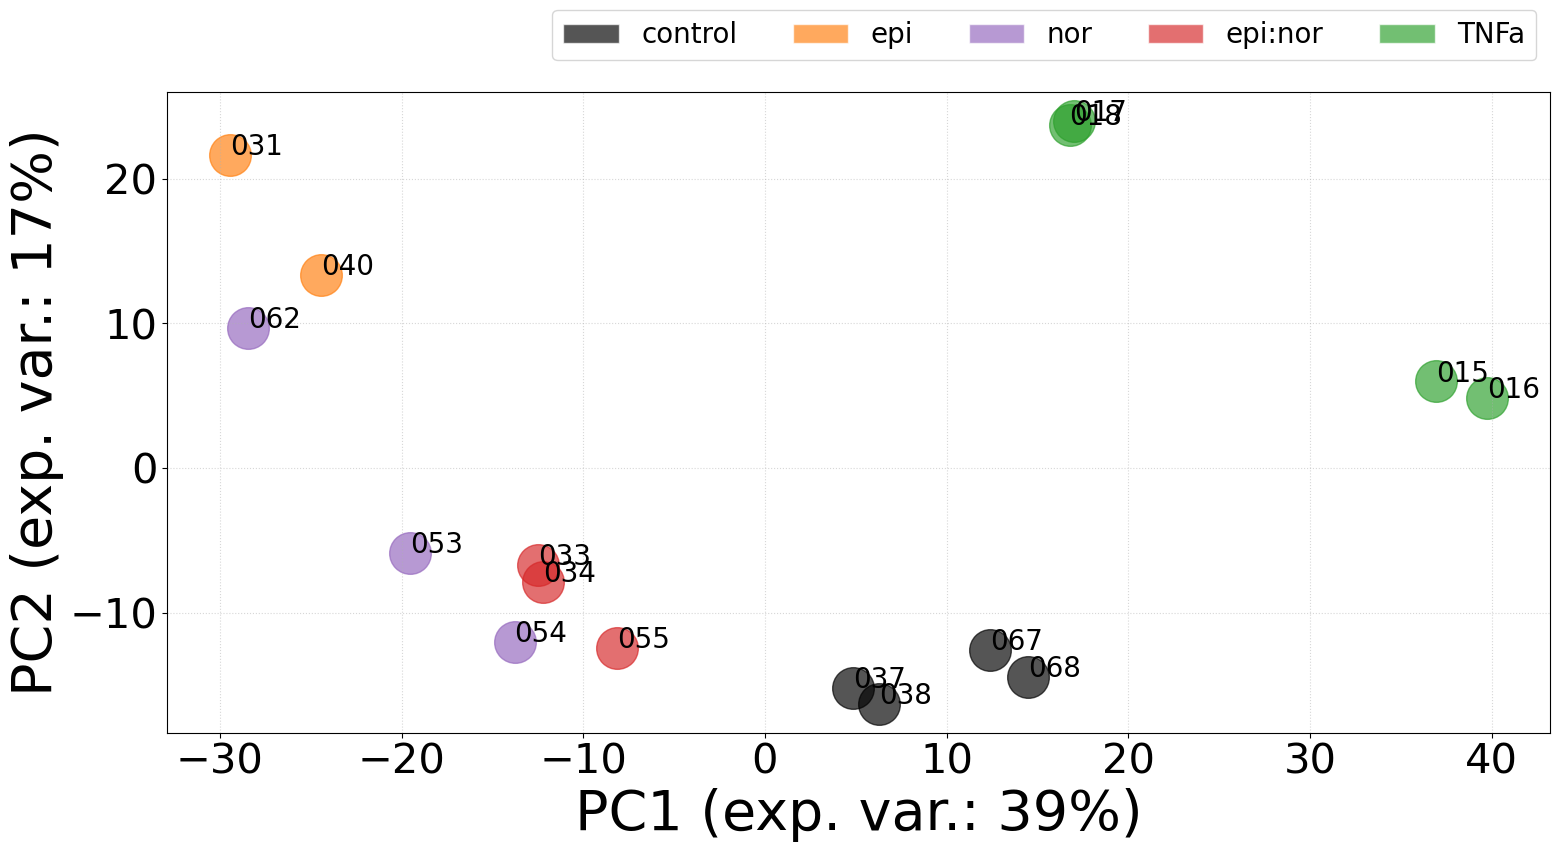

In [39]:
# excluding arbitrary samples
excluded_sample_tags = ['022', '023', '042', '043', '006', '007', '028']
print(len(excluded_sample_tags)) # should be 7
excluded_samples = ['20220905_ARNAR_' + element for element in excluded_sample_tags]
print(excluded_samples)
simplified_df = new24.drop(excluded_samples, axis=1)
print(simplified_df.shape)

# normalization
# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(simplified_df.values, axis=0), index=simplified_df.index, columns=simplified_df.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = simplified_df.rank(method="min").stack().astype(int).map(df_mean).unstack()

# PCA
transpose = qndf.transpose()
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(transpose)
model = sklearn.decomposition.PCA(n_components=2)
locations = model.fit_transform(scaled_data)
explained = model.explained_variance_ratio_
print(explained)

for i in range(len(locations)):
    
    the_marker = 'o'
    the_label = qndf.columns[i].split('_')[-1]
        
    if simplified_df.columns[i] in metadata['24h control']:
        the_color = 'black'
    elif simplified_df.columns[i] in metadata['24h epi']:
        the_color = 'tab:orange'
    elif simplified_df.columns[i] in metadata['24h nor']:
        the_color = 'tab:purple'
    elif simplified_df.columns[i] in metadata['24h epinor']:
        the_color = 'tab:red'
    elif simplified_df.columns[i] in metadata['24h TNFa']:
        the_color = 'tab:green'
    else:
        raise ValueError('sample not classified')
    
    matplotlib.pyplot.scatter(locations[i,0], locations[i,1], s=900, c=the_color, marker=the_marker, alpha=2/3)
    matplotlib.pyplot.text(locations[i, 0], locations[i, 1], the_label)
    
    
legend_elements = [ 
    matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:orange', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:purple', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
    matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3)
]
matplotlib.pyplot.legend(legend_elements, ['control', 'epi', 'nor', 'epi:nor', 'TNFa'], ncol=5, bbox_to_anchor=(1, 1.15))

matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.title('quantile normalized post 24 hours')
matplotlib.pyplot.tight_layout()

There is more intra distance within TNFa than across epi:nor and control.
The grouping of different treatmens does not align.

### make comparisons

In [40]:
treatment_label = 'epi'
treatment_color = 'tab:orange'
control_samples = ['20220905_ARNAR_' + element for element in ['037', '038', '067', '068']]
treated_samples = ['20220905_ARNAR_' + element for element in ['031', '040']]
epi_response = comparison_function(qndf, treatment_label, treatment_color, control_samples, treated_samples)

TypeError: comparison_function() missing 1 required positional argument: 'treated_samples'

In [ ]:
treatment_label = 'nor'
treatment_color = 'tab:purple'
control_samples = ['20220905_ARNAR_' + element for element in ['037', '038', '067', '068']]
treated_samples = ['20220905_ARNAR_' + element for element in ['062', '053', '054']]
nor_response = comparison_function(qndf, treatment_label, treatment_color, control_samples, treated_samples)

In [ ]:
treatment_label = 'epi:nor'
treatment_color = 'tab:red'
control_samples = ['20220905_ARNAR_' + element for element in ['037', '038', '067', '068']]
treated_samples = ['20220905_ARNAR_' + element for element in ['033', '034', '055']]
epinor_response = comparison_function(qndf, treatment_label, treatment_color, control_samples, treated_samples)

In [ ]:
treatment_label = 'TNFa'
treatment_color = 'tab:green'
control_samples = ['20220905_ARNAR_' + element for element in ['037', '038', '067', '068']]
treated_samples = ['20220905_ARNAR_' + element for element in ['017', '018', '015', '016']]
tnfa_response = comparison_function(qndf, treatment_label, treatment_color, control_samples, treated_samples)

### Venn diagram of treatmens

In [ ]:
matplotlib_venn.venn3(
    [set(epi_response), set(nor_response), set(epinor_response)], 
    set_labels=('Epi', 'Nor', 'Epi:Nor'),
    set_colors=('tab:orange', 'tab:purple', 'tab:red'),
    alpha=2/3
)
matplotlib_venn.venn3_circles(
    [set(epi_response), set(nor_response), set(epinor_response)],
    linewidth=2
)
matplotlib.pyplot.show()

In [ ]:
matplotlib_venn.venn2(
    [set(epinor_response), set(tnfa_response)], 
    set_labels=('Epi:Nor', 'TNFa'),
    set_colors=('tab:red', 'tab:green'),
    alpha=2/3
)
matplotlib_venn.venn2_circles(
    [set(epinor_response), set(tnfa_response)],
    linewidth=2
)
matplotlib.pyplot.show()